# Generative Curation

### Synthetic Experiment Setup

##### Creating desirability function

In [ ]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from abc import ABC, abstractmethod
from scipy.spatial.distance import cdist
from scipy.linalg import cholesky
from scipy.spatial.distance import pdist, squareform
from shapely.geometry import Polygon

# Helper function for creating a mesh of points in a bounded space
def create_mesh(d, bound, num_points):
    # Create linspace for each dimension
    grids       = [np.linspace(bound[0], bound[1], num_points) for i in range(d)]
    mesh        = np.meshgrid(*grids, indexing='ij')
    mesh_points = np.stack(mesh, axis=-1).reshape(-1, d)
    return mesh_points

# Helper function for calculating hamming distance
def hamming_distance_matrix(A):
    # Use pdist to compute pairwise Hamming distances, then convert to a square matrix
    hdist = squareform(pdist(A, metric='hamming'))
    return hdist

# Helper function for Gaussian Process realization with Discrete Space
def discrete_gaussian_process_realization(A, length_scale=1.0):
    # Compute the Hamming distance matrix
    hdist = hamming_distance_matrix(A)
    # Compute the covariance matrix using the RBF kernel
    K = np.exp(- .5 * hdist / length_scale)
    # Generate Gaussian process realizations
    realization = np.random.multivariate_normal(mean=np.zeros(A.shape[0]), cov=K)
    return realization

# Helper function for Gaussian Process realization with Continuous Space
def gaussian_process_realization(d, bound, num_points, length_scale):
    # Generate random points in d-dimensional space
    A = create_mesh(d, bound=bound, num_points=num_points)
    # Calculate pairwise distances
    pairwise_dists = cdist(A, A, 'euclidean')
    # Exponential kernel
    K = np.exp(- .5 * pairwise_dists ** 2 / length_scale)
    # Cholesky decomposition for generating realizations
    L = cholesky(K + 1e-6 * np.eye(len(A)), lower=True)
    u = np.random.randn(len(A))
    realization = np.dot(L, u)
    return A, realization

# Abstract Black-Box Optimization Class
class BlackBoxDesirability(ABC):

    def __init__(self, A, d, p, bound, n_grid, length_scale):
        self.p      = p
        self.bound  = bound
        self.n_grid = n_grid
        self.d      = d
        if bound is not None:
            # continuous space
            self.A, self.U = gaussian_process_realization(self.d, bound=bound, num_points=n_grid, length_scale=length_scale)
        else:
            # discrete space
            self.A = A
            self.U = discrete_gaussian_process_realization(A, length_scale=length_scale)
        self.Y   = np.array([ self.y(a) for a in self.A ])
        self.Ell = self.p * self.Y + (1 - self.p) * self.U

    @abstractmethod
    def y(self, a):
        pass

    def u(self, a):
        if self.bound is not None:
            # Use nearest neighbor interpolation for simplicity
            dist = np.linalg.norm(self.A - a, axis=1)
            idx  = np.argmin(dist)
        else:
            idx = np.where(self.A == a)[0][0]
        return self.U[idx]

    def ell(self, a):
        return self.p * self.y(a) + (1 - self.p) * self.u(a)

    def true_optimal(self):
        opt_idx = np.argmax(self.Ell)
        return self.A[opt_idx], self.Ell[opt_idx]

    def quant_optimal(self):
        opt_idx = np.argmax(self.Y)
        return self.A[opt_idx], self.Ell[opt_idx]

# Subclass for 2D Ackley Function
class Ackley(BlackBoxDesirability):

    def __init__(self, d, p, bound=(-1., 1.), n_grid=50, length_scale=5e-1):
        super().__init__(A=None, d=d, p=p, bound=bound, n_grid=n_grid, length_scale=length_scale)

    def y(self, a):
        # Ackley function formula
        z = 20
        b = .2
        c = 2 * np.pi
        sum1 = np.sum(a**2)
        sum2 = np.sum(np.cos(c * a))
        term1 = -z * np.exp(-b * np.sqrt(sum1 / self.d))
        term2 = -np.exp(sum2 / self.d)
        return - term1 - term2 - z - np.exp(1)

# Subclass for 2D Gaussian Function
class Gaussian(BlackBoxDesirability):
    def __init__(self, d, p, bound=(-1., 1.), n_grid=50, length_scale=5e-1):
        super().__init__(A=None, d=d, p=p, bound=bound, n_grid=n_grid, length_scale=length_scale)

    def y(self, a):
        return np.exp(-0.5 * np.sum(a**2)) / (2 * np.pi)**self.d

# Subclass for Knapsack Problem
class Knapsack(BlackBoxDesirability):

    def __init__(self, p, length_scale, weights, values, max_weight):
        # Define the items with their weights and values
        self.weights    = weights
        self.values     = values
        # Define the knapsack capacity
        self.max_weight = max_weight
        # Generate solutions
        A               = self.knapsack_solutions(weights, max_weight, len(weights))
        super().__init__(A=A, d=A.shape[1], p=p, bound=None, n_grid=None, length_scale=length_scale)

    def y(self, a):
        return np.dot(a, self.values)

    # Function to generate all possible solutions
    @staticmethod
    def knapsack_solutions(weights, max_weight, N):
        # Total number of possible solutions (2^n)
        total_solutions = 2 ** N
        # Initialize lists to store results
        A = []
        # Iterate through all possible binary vectors
        for i in range(total_solutions):
            # Generate binary vector
            a            = np.array(list(np.binary_repr(i, width=N)), dtype=int)
            # Calculate total weight and value
            total_weight = np.dot(a, weights)
            # Check if the solution is feasible
            if total_weight <= max_weight:
                A.append(a)
        return np.stack(A, 0)

# Subclass for Police Redistricting Problem
class Redistricting(BlackBoxDesirability):

    def __init__(self, p, length_scale, geojson_file, workload_file, n_swap=5, n=100):
        # extract initial plan, list of beats, and their adjacency matrix
        zones, self.beats, self.adj, self.gdf = self.load_geojson(geojson_file)
        # load workload into a dictionary
        self.workload_dict = self.load_workload(workload_file)
        self.workloads     = np.array([
            self.workload_dict[beat] for beat in self.beats ])
        # generate solutions
        self.init_zones    = zones
        A = self.redistricting_solution(zones, self.adj, n_swap=n_swap, n=n)
        super().__init__(A=A, d=A.shape[1], p=p, bound=None, n_grid=None, length_scale=length_scale)

    def y(self, a):
        a       = a.reshape(len(self.beats), -1)
        n_zones = a.shape[1]
        sums    = []
        for z in range(n_zones):
            sums.append((a[:, z] * self.workloads).sum())
        return - np.var(np.array(sums))

    def convert_a_to_zones(self, a):
        # convert binary decision matrix to the list of zone assignment
        a       = a.reshape(len(self.beats), -1)
        n_zones = a.shape[1]
        sums    = []
        zones   = np.argmax(a, 1) + 1
        return zones

    # Function to generate all possible solutions
    @staticmethod
    def redistricting_solution(init_zones, adj_matrix, n_swap, n):

        # convert the list of zone assignment to binary decision matrix
        def convert_zones_to_a(zones):
            a = np.zeros((len(zones), len(set(zones))), dtype=int)
            for i, z in zip(range(len(zones)), zones):
                a[i, z-1] = 1
            return a

        # swap the zone assignments between beat i and beat j in decision a
        def swap_zone_assignments(i, j, zones):
            z = np.copy(zones)
            z[i] = z[j]
            return z

        # randomly select two beats that are adjacent to each other and are from the same zone
        def random_adjacent_beats_in_diff_zone(zones, adj):
            # get the indices of non-zero entries
            nonzero_indices = np.argwhere(adj == 1)
            indices         = np.array([
                [i, j] for i, j in nonzero_indices if zones[i] != zones[j]])
            if indices.size == 0:
                raise ValueError("The matrix has no non-zero entries.")
            # randomly select one of the non-zero entries
            random_idx = np.random.choice(len(indices))
            # return the row and column indices
            return indices[random_idx]

        A = []
        for _ in range(n):
            z = np.array(np.copy(init_zones))
            for _ in range(n_swap):
                i, j = random_adjacent_beats_in_diff_zone(z, adj_matrix)
                z    = swap_zone_assignments(i, j, z)
                A.append(convert_zones_to_a(z).reshape(-1))
        return np.stack(A, 0)

    # Function to load workload information from csv file
    @staticmethod
    def load_workload(workload_file):
        workload_dict = {}
        with open("workload.csv", 'r') as csvfile:
            csvreader = csv.reader(csvfile)
            next(csvreader)
            # iterate through each row in the CSV file
            for row in csvreader:
                workload_dict[row[0]] = float(row[1])
            return workload_dict

    # Function to extract topological information from geojson
    @staticmethod
    def load_geojson(geojson):
        # Load and handle geometries
        gdf        = gpd.read_file(geojson)
        gdf        = gdf[gdf['BEAT'] != '050'].reset_index(drop=True) # remove beat 050
        # retrieve beat information
        beats      = gdf['BEAT'].astype(str).tolist()
        # extract the initial zone plan
        zones      = gdf['BEAT'].astype(str).str[0].astype(int).tolist()
        # create an adjacency matrix, initializing it with zeros
        n          = len(gdf)
        adj_matrix = np.zeros((n, n), dtype=int)
        # create the adjacency matrix
        for i in range(n):
            for j in range(i+1, n):  # Check only pairs to avoid redundant checks
                if gdf.geometry[i].touches(gdf.geometry[j]):  # Check if beats share a boundary
                    adj_matrix[i, j] = 1
                    adj_matrix[j, i] = 1
        return zones, beats, adj_matrix, gdf

##### Visualization Tools

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
from tqdm import tqdm

def moving_average(arr, window_size):
    """
    Compute the moving average of a 1D array with a given window size and remove NaN values.

    Parameters:
    arr (list or np.ndarray): The input array of values.
    window_size (int): The size of the moving average window.

    Returns:
    np.ndarray: The moving average of the input array with NaN values removed.
    """
    # Ensure the window size is valid
    if window_size is None:
        return arr

    # Convert the input array to a numpy array if it is not already
    arr = np.asarray(arr)

    # Compute the moving average using convolution
    cumsum = np.cumsum(arr, dtype=float)
    cumsum[window_size:] = cumsum[window_size:] - cumsum[:-window_size]
    moving_avg = cumsum[window_size - 1:] / window_size

    return moving_avg

def plot_districting(init_zones, zones, workloads, gdf):

    # extract changed beats
    def filter_gdf(init_zones, zones, gdf):
        fgdfs = []
        for i, init_z, z in zip(range(len(zones)), init_zones, zones):
            if init_z != z:
                fgdfs.append(gdf.iloc[[i]])
        return fgdfs

    # calculate agg_workload for each zone
    def calculate_agg_workloads(zones, workloads):
        zone_workloads, agg_workloads = [], []
        for z in range(len(set(zones))):
            zone_workloads.append(workloads[np.where(zones == z + 1)[0]].sum())
        for b in range(len(workloads)):
            agg_workloads.append(zone_workloads[zones[b] - 1])
        return np.array(agg_workloads)

    init_zones, zones, workloads = np.array(init_zones), np.array(zones), np.array(workloads)

    init_agg_workloads = calculate_agg_workloads(init_zones, workloads)
    agg_workloads      = calculate_agg_workloads(zones, workloads)
    wmin, wmax         = init_agg_workloads.min(), init_agg_workloads.max()

    gdf['INIT_ZONE']    = init_zones
    gdf['ZONE']         = zones
    gdf['WORKLOADS']    = np.log(workloads + 10)
    gdf['AGG_WORKLOAD'] = agg_workloads
    fgdfs               = filter_gdf(init_zones, zones, gdf)
    print("init variance:", np.var(init_agg_workloads))
    print("variance:", np.var(agg_workloads))

    # merge polygons based on the first digit of the 'BEAT' value
    gdf_new = gdf.dissolve(by='ZONE')

    fig, ax = plt.subplots(figsize=(10, 10))
    gdf.plot(ax=ax, column='AGG_WORKLOAD', cmap='Greys', vmin=wmin, vmax=wmax)
    gdf.boundary.plot(ax=ax, linewidth=1, color='gray')           # Thicker border and no fill color
    for fgdf in fgdfs:
        fgdf.boundary.plot(ax=ax, linewidth=6, color='red', linestyle='--')  # Dashed border
    gdf_new.boundary.plot(ax=ax, linewidth=6, color='black')  # Thicker border and no fill color

    ax.axis('off')
    plt.show()

def visualize_objective_function(desrb):
    if desrb.d != 2:
        raise ValueError("Visualization is only implemented for 2D functions.")

    grids = [np.linspace(desrb.bound[0], desrb.bound[1], desrb.n_grid) for i in range(desrb.d)]
    X, Y  = np.meshgrid(*grids)
    Z     = np.array([desrb.ell(np.array([x_i, y_i])) for x_i, y_i in zip(np.ravel(X), np.ravel(Y))])
    Zy    = np.array([desrb.y(np.array([x_i, y_i])) for x_i, y_i in zip(np.ravel(X), np.ravel(Y))])
    Z     = Z.reshape(X.shape)
    Zy    = Zy.reshape(X.shape)

    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, Zy, cmap='Greys', edgecolor='none', alpha=1.)
    ax.plot_surface(X, Y, Z, cmap='Reds', edgecolor='none', alpha=.5)
    fake_ell = mpl.lines.Line2D([0],[0], linestyle="none", c='red', marker = 'o')
    fake_y   = mpl.lines.Line2D([0],[0], linestyle="none", c='grey', marker = 'o')
    ax.legend(
        [fake_ell, fake_y],
        ['True desirability $\ell$', 'Quantitative desirability $Y$'], numpoints = 1)

    ax.set_xlabel('1st dim of $A$')
    ax.set_ylabel('2nd dim of $A$')
    # ax.set_zlabel('Desirability')
    ax.text(-4.5, -3.5, -6, "Desirability", 'z')
    plt.show()

def visualize_generative_policy(policy, noise_dim, num_points=10000, m=20):
    # Generate random 2D points
    z       = torch.normal(0, noise_std, size=(num_points, noise_dim))
    actions = model(z).detach().numpy()
    x, y    = actions[:, 0], actions[:, 1]

    # Create a 3D plot
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111, projection='3d')

    # Plot the points on the bottom (XY-plane) in black
    ax.scatter(x[:m], y[:m], np.zeros_like(x[:m]), color='black', marker='o', s=6)

    # Perform Kernel Density Estimation (KDE)
    xy = np.vstack([x, y])
    kde = gaussian_kde(xy)
    kde.set_bandwidth(bw_method=kde.factor * 0.5)

    # Create a grid over the XY-plane
    x_grid, y_grid = np.meshgrid(np.linspace(-3, 3, 50),
                                np.linspace(-3, 3, 50))
    z_grid = kde(np.vstack([x_grid.ravel(), y_grid.ravel()])).reshape(x_grid.shape)

    # Plot the KDE surface in blue with transparency
    ax.plot_surface(x_grid, y_grid, z_grid, color='blue', alpha=0.5, rstride=1, cstride=1)
    fake_z = mpl.lines.Line2D([0],[0], linestyle="none", c='blue', marker = 'o')
    fake_a = mpl.lines.Line2D([0],[0], linestyle="none", c='black', marker = 'o')
    ax.legend(
        [fake_z, fake_a],
        ['Policy $\pi$', 'Actions $a_1,\dots,a_m$'], numpoints = 1)

    # Set labels and show the plot
    # Remove the z-axis ticks and labels, but keep the grid
    # ax.zaxis.set_ticks([])  # Remove the ticks
    ax.zaxis.set_ticklabels([])  # Remove the tick labels
    ax.grid(True)  # Ensure grid is on

    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)
    ax.set_zlim(0, .3)
    ax.set_xlabel('1st dim of $A$')
    ax.set_ylabel('2nd dim of $A$')
    # ax.set_zlabel('Density')
    ax.text(-3.5, -3.5, 0.15, "Density", 'z')
    # ax.set_title('Random 2D Points with KDE Surface')

    plt.show()

def plot_regret_vs_iterations(iters, regrets_D, diversity, lpct=20, upct=80, window_size=None):
    """
    Plots the regret vs epsilon.
    """
    fig, ax1 = plt.subplots(figsize=(6, 5))
    iters    = moving_average(iters, window_size)
    # diversity
    mean_div      = moving_average(np.mean(diversity, 1), window_size)
    max_div       = moving_average(np.percentile(diversity, upct, 1), window_size)
    min_div       = moving_average(np.percentile(diversity, lpct, 1), window_size)
    # regret
    mean_regret_D = moving_average(np.mean(regrets_D, 1), window_size)
    max_regret_D  = moving_average(np.percentile(regrets_D, upct, 1), window_size)
    min_regret_D  = moving_average(np.percentile(regrets_D, lpct, 1), window_size)
    ax1.set_xlabel('Iteration $t$')
    ax1.set_ylabel('Regret', color='red')
    plt.fill_between(iters, min_regret_D, max_regret_D, color='red', alpha=0.1)
    ax1.plot(iters, mean_regret_D, color='red', linestyle='--', linewidth=2, label='True regret of $\pi_t$')
    # ax1.set_ylim(0, 0.17)

    # Create a secondary y-axis (right)
    ax2 = ax1.twinx()
    plt.fill_between(iters, min_div, max_div, color='blue', alpha=0.1)
    ax2.plot(iters, mean_div, color='blue', linestyle='--', linewidth=2, label=r'Diversity $\sqrt{1 - \rho[\pi_t]}$')
    ax2.set_ylabel('Diversity', color='blue')
    ax2.tick_params(axis='y', labelcolor='blue')

    for spine in ax1.spines.values():
        spine.set_linewidth(2)  # Adjust the value to make the lines thicker or thinner
    for spine in ax2.spines.values():
        spine.set_linewidth(2)  # Adjust the value to make the lines thicker or thinner
    fig.legend(loc='upper left', bbox_to_anchor=(0.15,0.85))
    plt.show()

def plot_regret_vs_sigma(sigma, regrets, other_regrets, other_models, colors, lpct=20, upct=80, window_size=None):
    """
    Plots the regret vs epsilon.
    """
    # regrets       = (regrets - np.min(regrets)) / (np.max(regrets) - np.min(regrets))
    # other_regrets = (other_regrets - np.min(regrets)) / (np.max(regrets) - np.min(regrets))

    fig, ax = plt.subplots(figsize=(6, 5))
    # regret
    mean_regret = np.mean(regrets, 1)
    max_regret  = np.percentile(regrets, upct, 1)
    min_regret  = np.percentile(regrets, lpct, 1)
    ax.set_xlabel('$\sigma$')
    ax.set_ylabel('Regret')

    for other_regret, other_model, c in zip(other_regrets, other_models, colors):
        plt.axhline(other_regret, color=c, linestyle='--', linewidth=2, label=other_model)
    plt.bar(sigma, mean_regret, yerr=[min_regret, max_regret], capsize=5, color='red', alpha=0.5, edgecolor='black', label='DIS-GC')
    # ax.set_xticklabels(sigma)
    for spine in ax.spines.values():
        spine.set_linewidth(2)  # Adjust the value to make the lines thicker or thinner

    fig.legend(bbox_to_anchor=(0.89,0.86))
    plt.show()

##### Examples

most desirable action: [0.06122449 0.06122449], optimal desirability: 0.413551
regret of quantitatively optimal action [0.06122449 0.06122449]: 0.000000


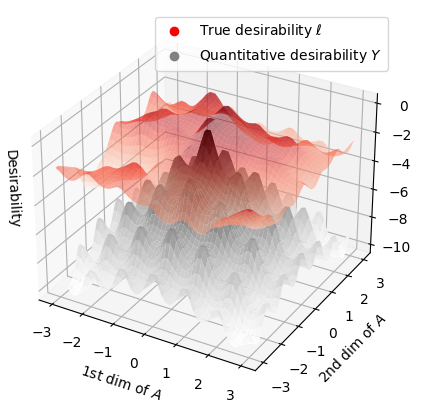

most desirable action: [-0.02040816 -0.06122449], optimal desirability: 0.026189
regret of quantitatively optimal action [-0.02040816 -0.02040816]: 0.000074


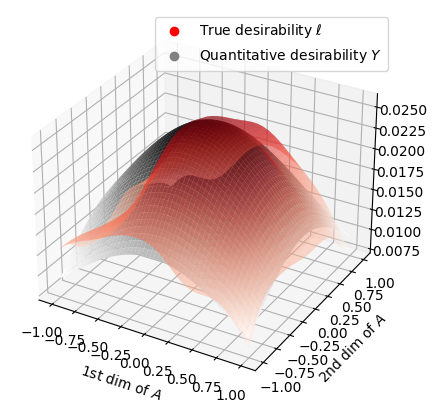

In [ ]:
# Example usage

ackley = Ackley(d=2, p=.3, bound=(-3., 3.), length_scale=5e-1)
a_star, ell_star = ackley.true_optimal()
a, ell           = ackley.quant_optimal()
print("most desirable action: %s, optimal desirability: %f" % (a_star, ell_star))
print("regret of quantitatively optimal action %s: %f" % (a, ell_star - ell))
visualize_objective_function(ackley)

gauss = Gaussian(d=2, p=.998, length_scale=1e-1)
a_star, ell_star = gauss.true_optimal()
a, ell           = gauss.quant_optimal()
print("most desirable action: %s, optimal desirability: %f" % (a_star, ell_star))
print("regret of quantitatively optimal action %s: %f" % (a, ell_star - ell))
visualize_objective_function(gauss)

In [ ]:
weights    = np.random.randint(0, 10, size=10)
values     = np.random.randint(0, 10, size=10)
max_weight = 20

print("weights:", weights)
print("values:", values)
print("max_weight:", max_weight)

knap = Knapsack(p=.1, length_scale=5e-1,
                weights=weights,
                values=values,
                max_weight=max_weight)

a_star, ell_star = knap.true_optimal()
a, ell           = knap.quant_optimal()

print(len(knap.A), knap.A)
print("most desirable action: %s, optimal desirability: %f" % (a_star, ell_star))
print("regret of quantitatively optimal action %s: %f" % (a, ell_star - ell))

weights: [9 9 6 4 0 4 8 2 1 5]
values: [0 7 8 9 9 0 1 6 6 7]
max_weight: 20
366 [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 1 0]
 ...
 [1 1 0 ... 0 0 0]
 [1 1 0 ... 0 1 0]
 [1 1 0 ... 1 0 0]]
most desirable action: [0 0 0 1 1 0 1 1 1 1], optimal desirability: 4.621913
regret of quantitatively optimal action [0 0 1 1 1 0 0 1 1 1]: 0.108262


In [ ]:
distr = Redistricting(p=.1, length_scale=5e-1,
                      geojson_file="2020_apd_beat.geojson",
                      workload_file="workload.csv",
                      n_swap=5, n=100)
print(distr.A)
print(distr.Y[:10])
print(distr.Ell[:10])

print(distr.A.shape)
print(distr.Y.shape)
print(distr.Ell.shape)

a_star, ell_star = distr.true_optimal()
a, ell           = distr.quant_optimal()
print("most desirable action: %s, optimal desirability: %f" % (a_star, ell_star))
print("regret of quantitatively optimal action %s: %f" % (a, ell_star - ell))

[[0 0 1 ... 1 0 0]
 [0 0 1 ... 1 0 0]
 [0 0 1 ... 1 0 0]
 ...
 [0 0 1 ... 1 0 0]
 [0 0 1 ... 1 0 0]
 [0 0 1 ... 1 0 0]]
[-10.8052393  -10.72466019 -10.67386833 -10.63473387 -10.68184768
  -9.00115077  -9.45956081  -9.50889238 -11.4077137  -11.23345616]
[-1.47695674 -1.67545591 -1.70584721 -1.6290181  -1.73913545 -1.28282245
 -1.43438333 -1.58421677 -1.80075339 -1.9204612 ]
(500, 468)
(500,)
(500,)
most desirable action: [0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0
 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0
 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0
 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0
 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 

### DIS-GC: Diversified Iterative Search for Generative Curation

In [ ]:
class DIS_GC(object):
    """
    A class representing the DIS_GC algorithm.
    """
    def __init__(self, Des, m=5, n=10, T=100, noise_level=1e-3, rate=1.01, verbose=True):
        self.Des    = Des
        self.rate   = rate
        self.T      = T
        self.m      = m
        self.n      = n                                                         # the number of history solutions in the state, it has to be odd number.
        # init state Bt
        Bt          = np.array([
            self.init_solver(noise_level)
            for _ in range(self.n) ])                                           # initial state             [ n ]
        # diversified interative search
        self.regrets    = []
        self.diversity  = []
        for t in range(self.T):
            noise_level = rate * noise_level
            Bt, div     = self.diversified_solver(Bt, noise_level)
            regret      = self.state_regret(Bt)
            self.regrets.append(regret)
            self.diversity.append(div)
            # break
            if t % 10 == 0 and verbose:
                print("iteration %d, noise_level: %f, regret: %f, diversity: %s" % (t, noise_level, regret, div))
        self.opt_inds   = Bt                                                    # [ n ]

    def init_solver(self, noise_level=.05):
        """
        The solver for intializing the state X.
        """
        opt_ind = np.argmax(self.Des.p * self.Des.Y +
                            np.random.normal(0, noise_level, len(self.Des.Y)))
        return opt_ind

    def diversified_solver(self, Bt, noise_level=.05):
        """
        The solver for the diversified iterative search.
        """
        new_Bt = np.copy(Bt)
        # calculate diversity term
        dist      = np.tile(self.Des.A, (self.n, 1, 1)) - \
            np.tile(self.Des.A[Bt], (len(self.Des.Y), 1, 1)).transpose(1, 0, 2)   # [ n, n_grid * n_grid, d ]
        rhos      = self.exponential_kernel(np.sqrt(np.sum(dist ** 2, axis=2))) # [ n, n_grid * n_grid ]
        Em        = np.sqrt(2 * np.log(self.m))
        diversity = np.sqrt(1 - rhos.mean(0)) * Em                                # [ n_grid * n_grid ]

        # determine the next action
        opt_ind   = np.argmax(self.Des.p * self.Des.Y +
                              (1 - self.Des.p) * diversity +
                              np.random.normal(0, noise_level, len(self.Des.Y)))

        # update the state
        new_Bt     = np.roll(new_Bt, shift=-1, axis=0)
        new_Bt[-1] = opt_ind
        return new_Bt, np.sqrt(1 - rhos.mean(0)[opt_ind])

    def exponential_kernel(self, dist, length_scale=5e-1):
        """
        Exponential kernel function.
        """
        return np.exp(- 0.5 * dist ** 2 / length_scale ** 2)

    def state_regret(self, Bt):
        """
        The regret measure.
        """
        return np.max(self.Des.Ell) - np.max(self.Des.Ell[Bt])

##### Ackley

100%|██████████| 50/50 [08:06<00:00,  9.72s/it]


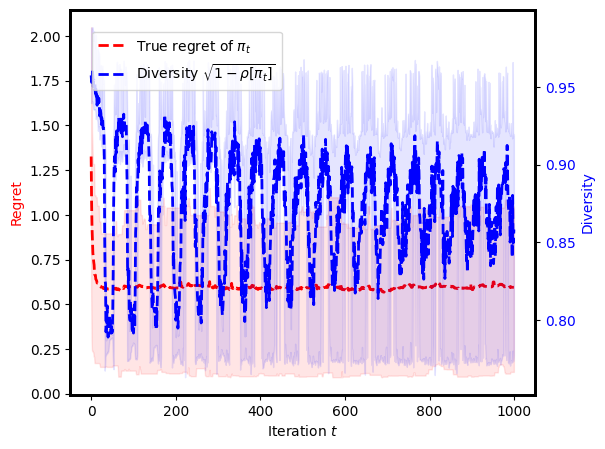

0.5946794653979878 0.12155567047989185 1.0464559206981272 0.8581229220705251


In [ ]:
T          = 1000 # Number of iterations
num_trials = 50
regs       = []
divs       = []
for _ in tqdm(range(num_trials)):
    ackley = Ackley(d=2, p=.1, bound=(-3., 3.), length_scale=5e-1)
    dis    = DIS_GC(ackley, m=5, n=50, T=T, noise_level=2e-2, rate=1., verbose=False)
    regs.append(dis.regrets)
    divs.append(dis.diversity)
regs  = np.array(regs).transpose()
divs  = np.array(divs).transpose()

plot_regret_vs_iterations(np.arange(T), regs, divs, lpct=20, upct=80, window_size=None)

print(regs[-1, :].mean(), np.percentile(regs[-1, :], 20), np.percentile(regs[-1, :], 80), divs[-1].mean())

##### Knapsack

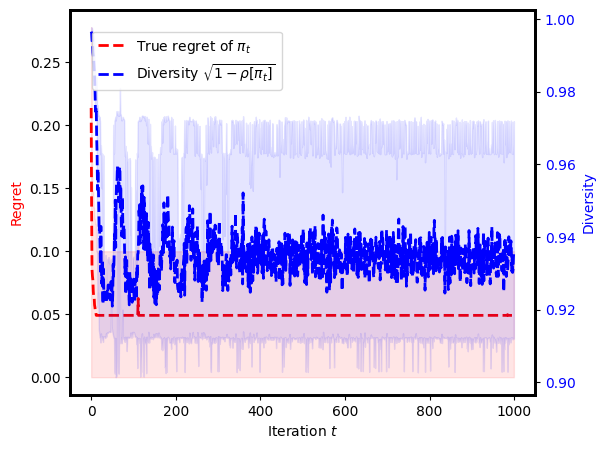

0.04913271828468311 0.0 0.15019560948614746 0.9361735607365316


In [ ]:
weights    = np.random.randint(0, 10, size=10)
values     = np.random.randint(0, 10, size=10)
max_weight = 20

print("weights:", weights)
print("values:", values)
print("max_weight:", max_weight)

T          = 1000 # Number of iterations
num_trials = 50
regs       = []
divs       = []
for _ in tqdm(range(num_trials)):
    knap = Knapsack(p=.1, length_scale=5e-1,
                    weights=weights,
                    values=values,
                    max_weight=max_weight)
    dis  = DIS_GC(knap, m=5, n=50, T=T, noise_level=2e-2, rate=1., verbose=False)
    regs.append(dis.regrets)
    divs.append(dis.diversity)
regs  = np.array(regs).transpose()
divs  = np.array(divs).transpose()

plot_regret_vs_iterations(np.arange(T), regs, divs, lpct=20, upct=80, window_size=None)

print(regs[-1, :].mean(), np.percentile(regs[-1, :], 10), np.percentile(regs[-1, :], 90), divs[-1].mean())

##### Police Redistricting

[1.00000000e+00 5.00000000e-01 9.09090909e-02 9.90099010e-03
 9.99000999e-04]


100%|██████████| 5/5 [1:48:43<00:00, 1304.61s/it]


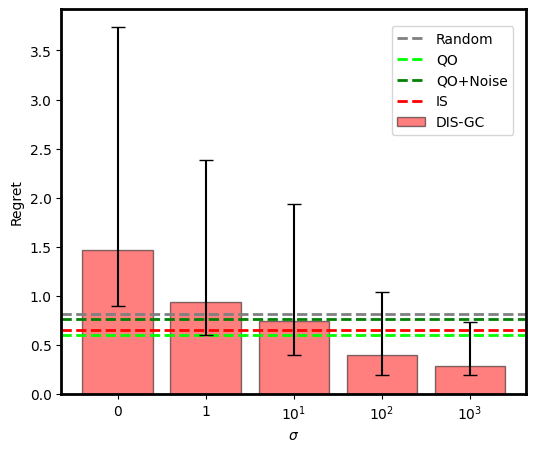

ValueError: mount failed

In [ ]:
T          = 200 # Number of iterations
n_swap     = 10
n          = 100
m          = 5
num_trails = 20

oracle_distr = Redistricting(p=1e-1, length_scale=5e-1,
                             geojson_file="2011beat.geojson",
                             workload_file="workload.csv",
                             n_swap=n_swap, n=n)
oracle_dis   = DIS_GC(oracle_distr, m=m, n=50, T=T, noise_level=2e-2, rate=1., verbose=False)

sigma     = np.array([0, 1, 10, 1e2, 1e3])
ps        = 1 / (sigma + 1)

print(ps)

regrets = []
for p in tqdm(ps):
    regs = []
    for _ in range(num_trails):
        distr = Redistricting(p=p, length_scale=5e-1,
                              geojson_file="2011beat.geojson",
                              workload_file="workload.csv",
                              n_swap=n_swap, n=n)
        dis   = DIS_GC(distr, m=m, n=50, T=T, noise_level=2e-2, rate=1., verbose=False)
        regs.append(oracle_dis.state_regret(dis.opt_inds))
    regrets.append(regs)
regrets = np.array(regrets)

# regrets = np.load('/content/drive/My Drive/regrets_sep_7.npy')

# upt_regrets = np.concatenate([new_regrets, regrets], axis=0)
# print(upt_regrets.shape)
# print(np.mean(regrets, 1), np.percentile(regrets, 10, axis=1), np.percentile(regrets, 90, axis=1))

plot_regret_vs_sigma(['$0$', '$1$', '$10^1$', '$10^2$', '$10^3$'],
                     regrets,
                     [0.82, 0.60, 0.77, 0.65],
                     ['Random', 'QO', 'QO+Noise', 'IS'],
                     ['gray', 'lime', 'green', 'red'],
                     lpct=10, upct=90)

from google.colab import drive
drive.mount('/content/drive')
np.save('/content/drive/My Drive/regrets_sep_7.npy', regrets)

100%|██████████| 5/5 [26:12<00:00, 314.53s/it]


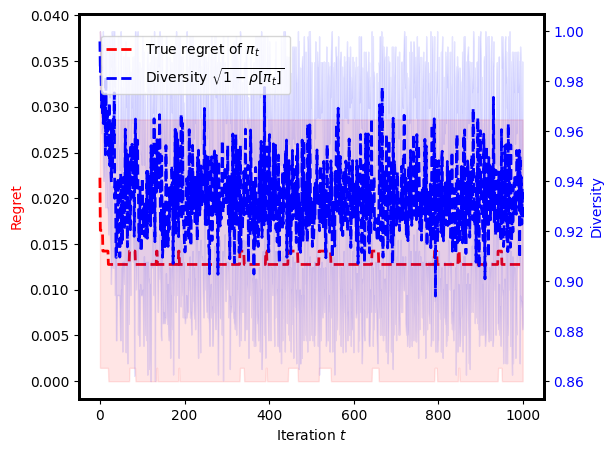

0.06383318381944565 0.0 0.1416958809020022 0.9247064839969232


In [ ]:
T          = 1000 # Number of iterations
num_trials = 5
regs       = []
divs       = []
for _ in tqdm(range(num_trials)):
    distr = Redistricting(p=1e-1, length_scale=5e-1,
                          geojson_file="2011beat.geojson",
                          workload_file="workload.csv",
                          n_swap=10, n=100)
    dis  = DIS_GC(distr, m=5, n=50, T=T, noise_level=2e-2, rate=1., verbose=False)
    regs.append(dis.regrets)
    divs.append(dis.diversity)
regs  = np.array(regs).transpose()
divs  = np.array(divs).transpose()

plot_regret_vs_iterations(np.arange(T), regs / 5, divs, lpct=5, upct=95, window_size=None)

print(regs[-1, :].mean(), np.percentile(regs[-1, :], 10), np.percentile(regs[-1, :], 90), divs[-1].mean())

100%|██████████| 1/1 [01:08<00:00, 68.80s/it]


init variance: 16.779355892893193
variance: 10.032929591099478


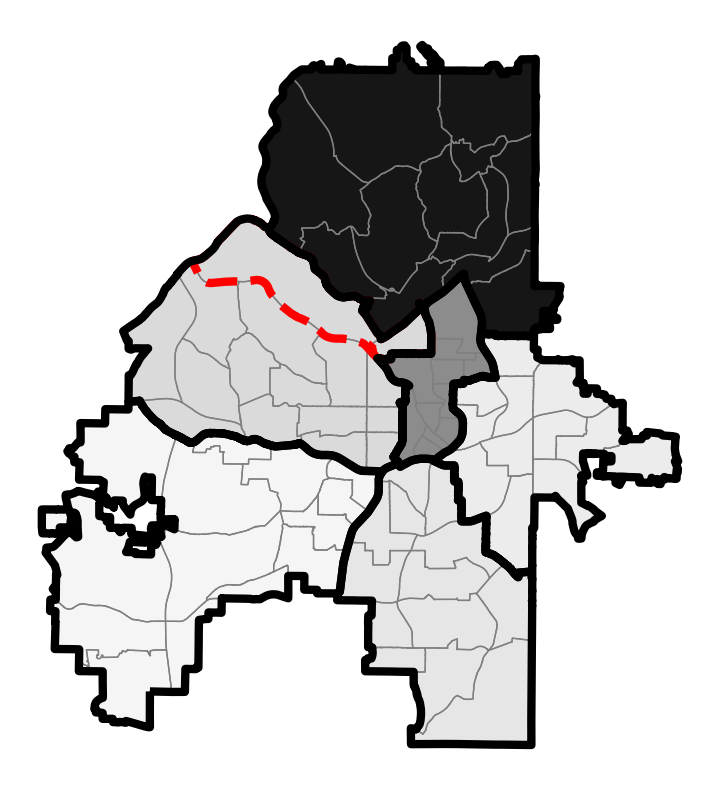

init variance: 16.779355892893193
variance: 11.041434736782314


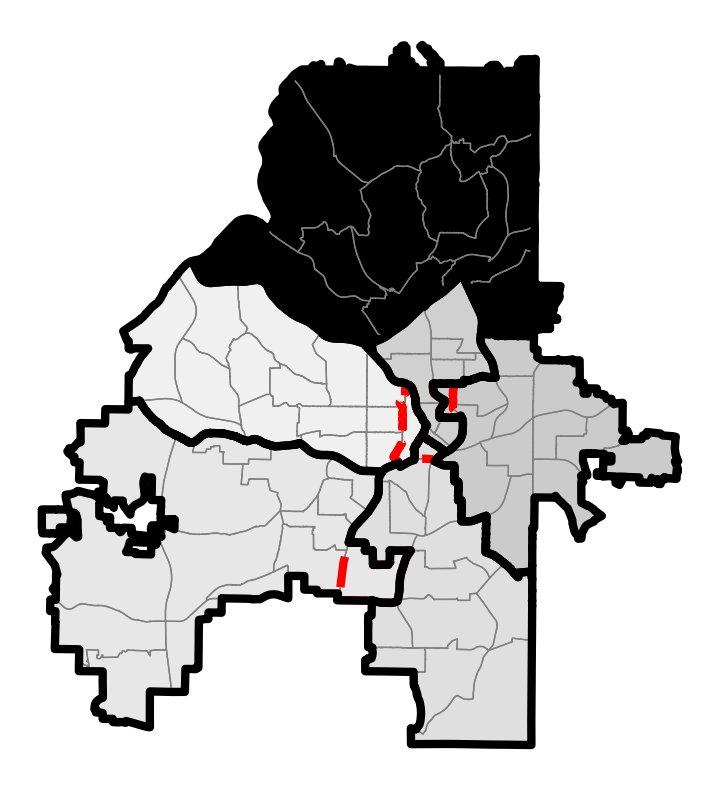

init variance: 16.779355892893193
variance: 8.812945591360432


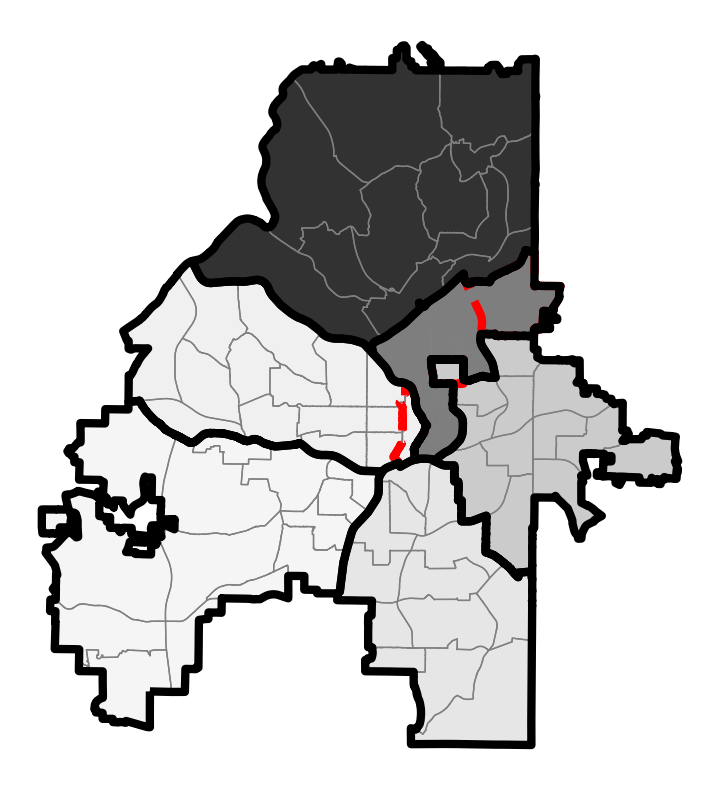

init variance: 16.779355892893193
variance: 8.797159938623901


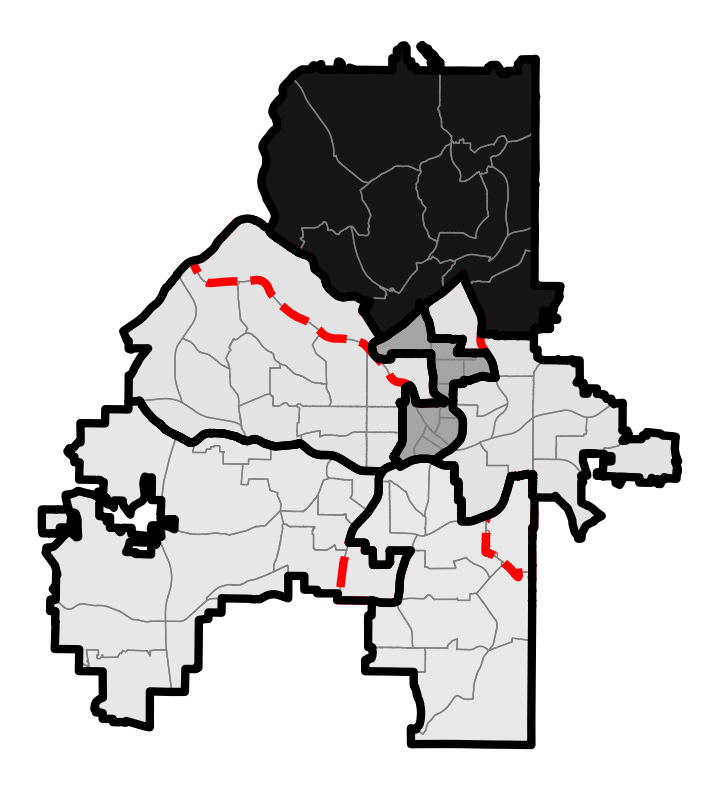

init variance: 16.779355892893193
variance: 13.055110674380108


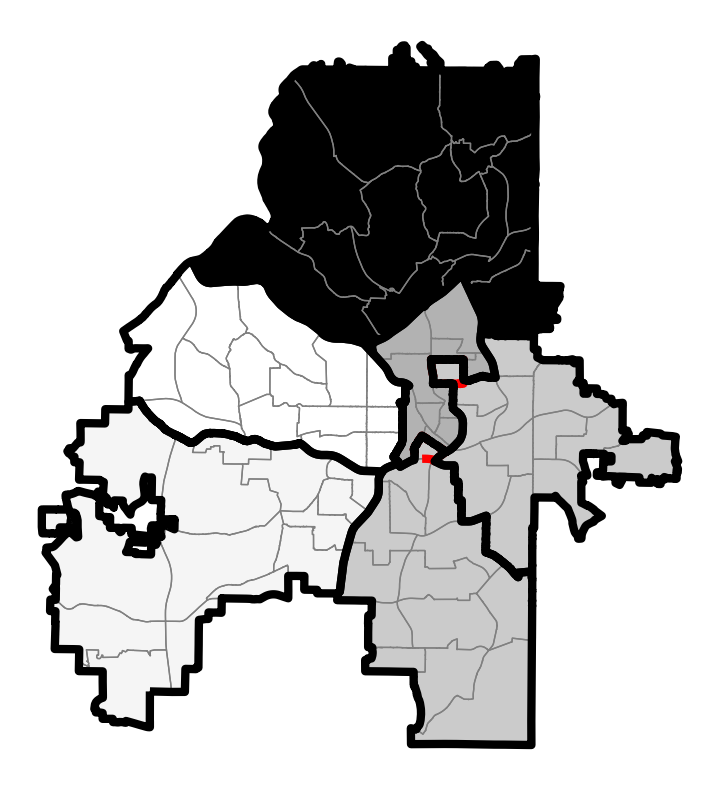

init variance: 16.779355892893193
variance: 11.639153083020968


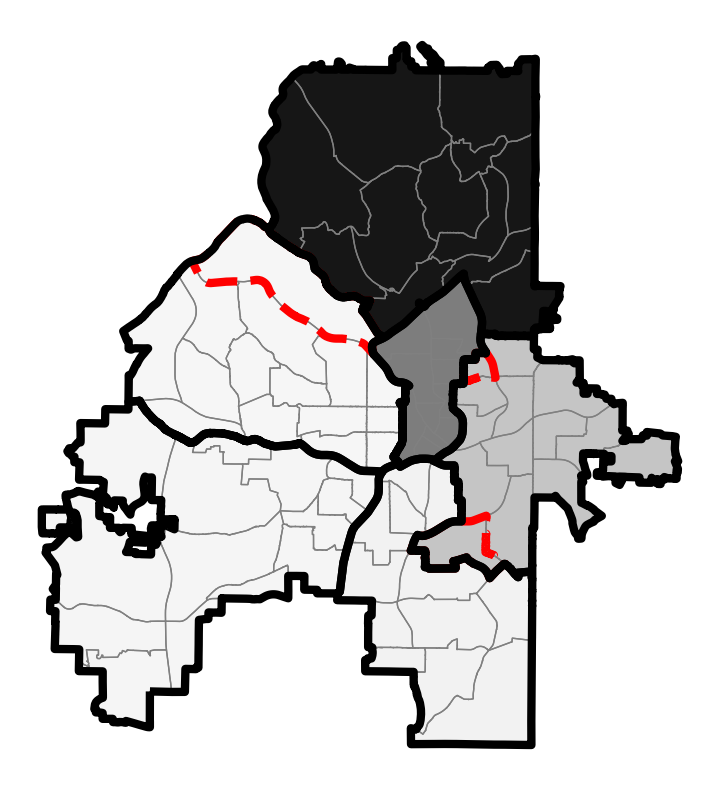

init variance: 16.779355892893193
variance: 11.357561188074984


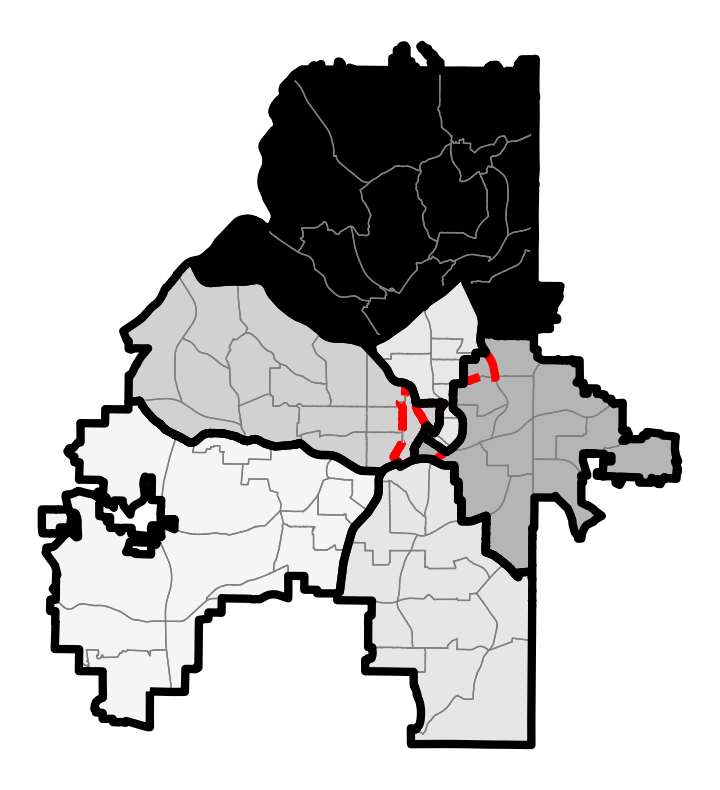

init variance: 16.779355892893193
variance: 8.94005138441649


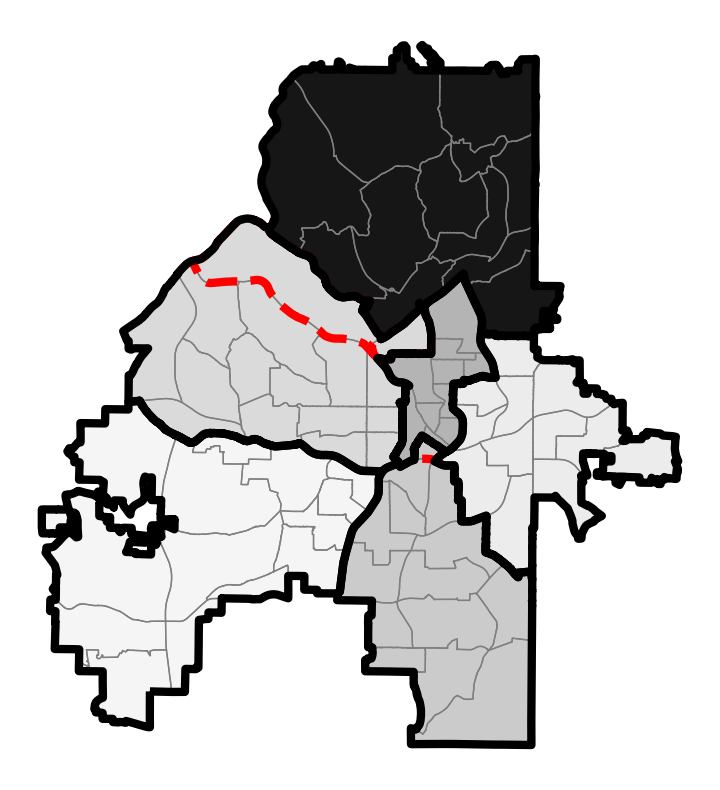

init variance: 16.779355892893193
variance: 7.164760209290755


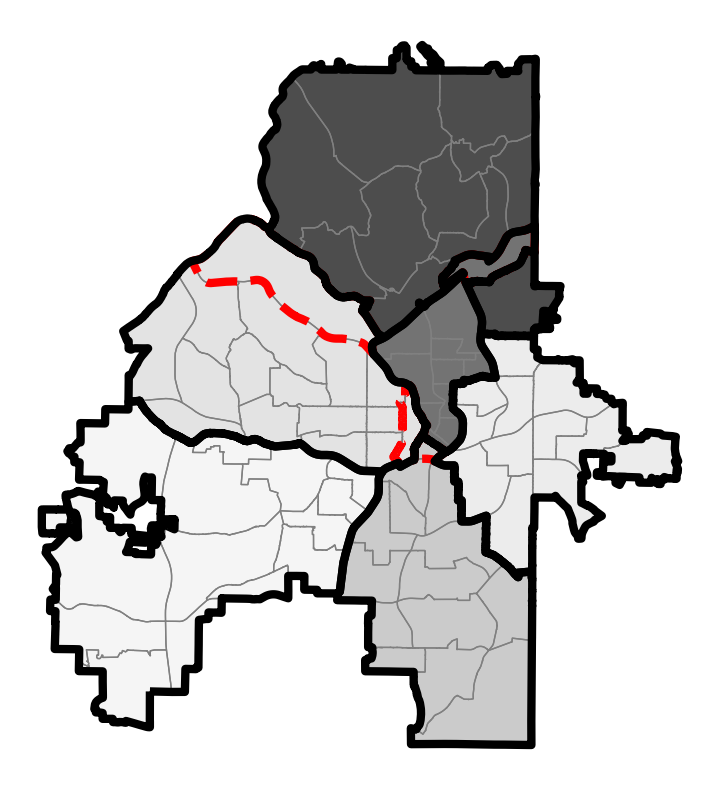

init variance: 16.779355892893193
variance: 8.434417611606785


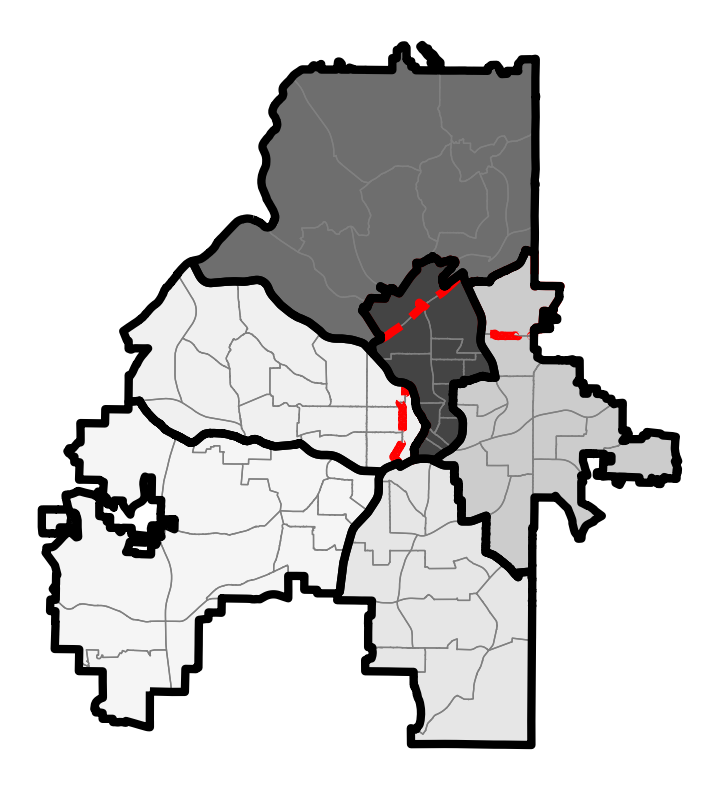

init variance: 16.779355892893193
variance: 9.330661392974289


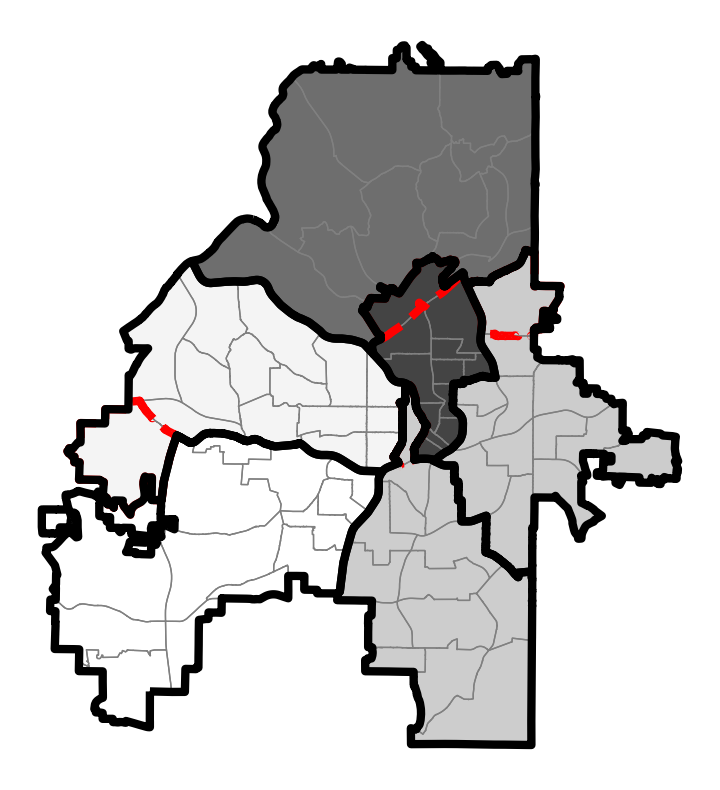

init variance: 16.779355892893193
variance: 8.94005138441649


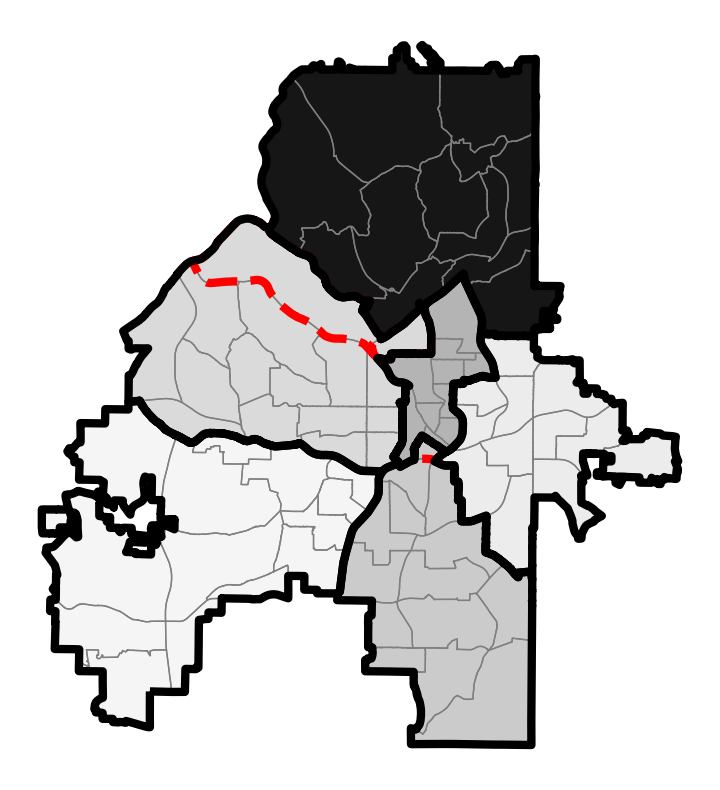

init variance: 16.779355892893193
variance: 8.812945591360432


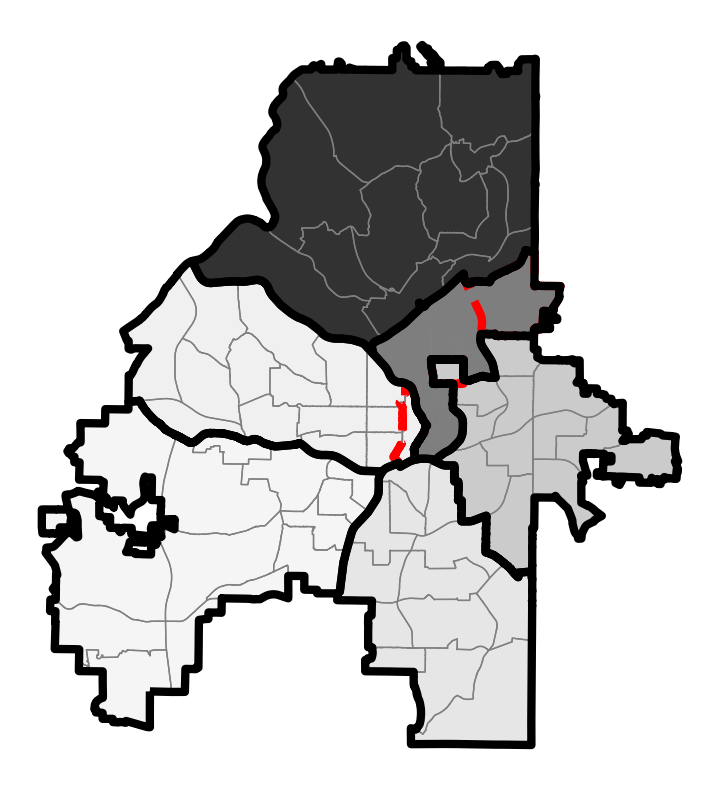

init variance: 16.779355892893193
variance: 11.339844660397477


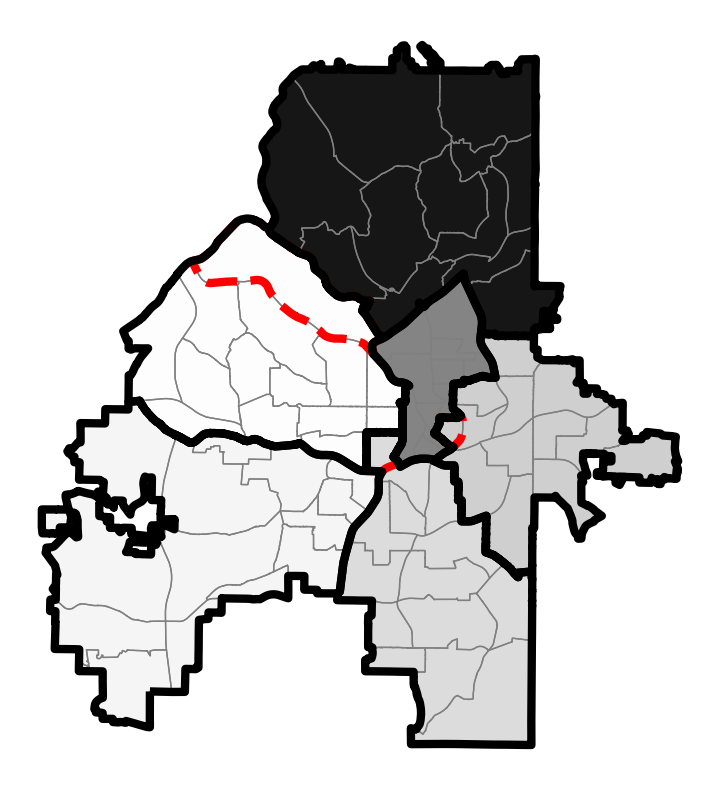

init variance: 16.779355892893193
variance: 12.053070882087253


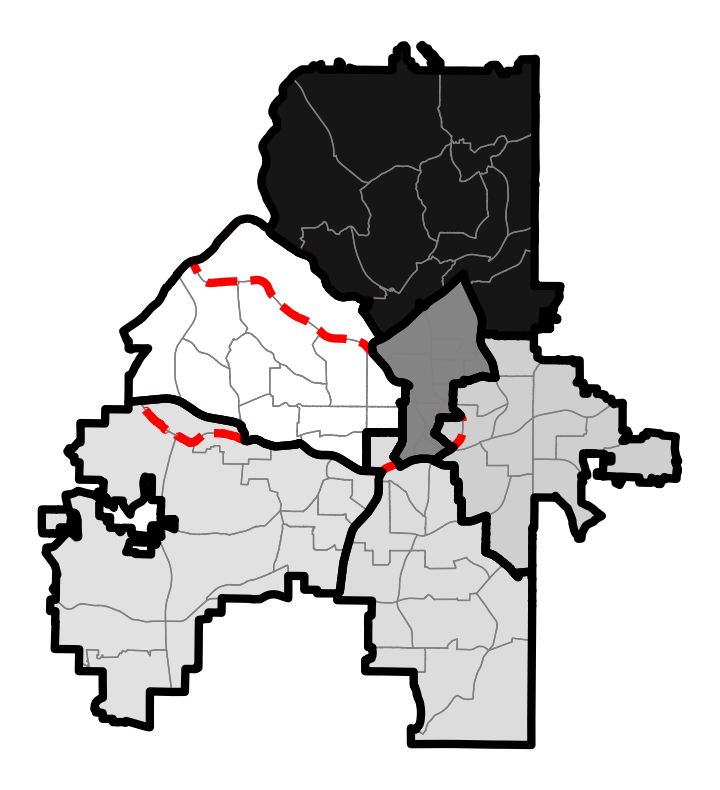

init variance: 16.779355892893193
variance: 9.413334004076244


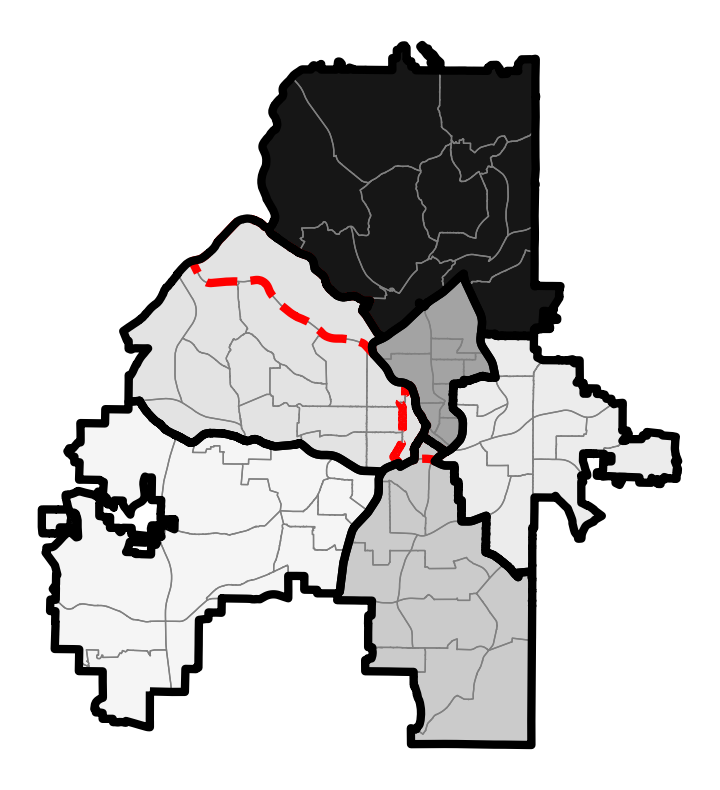

init variance: 16.779355892893193
variance: 11.72869368346092


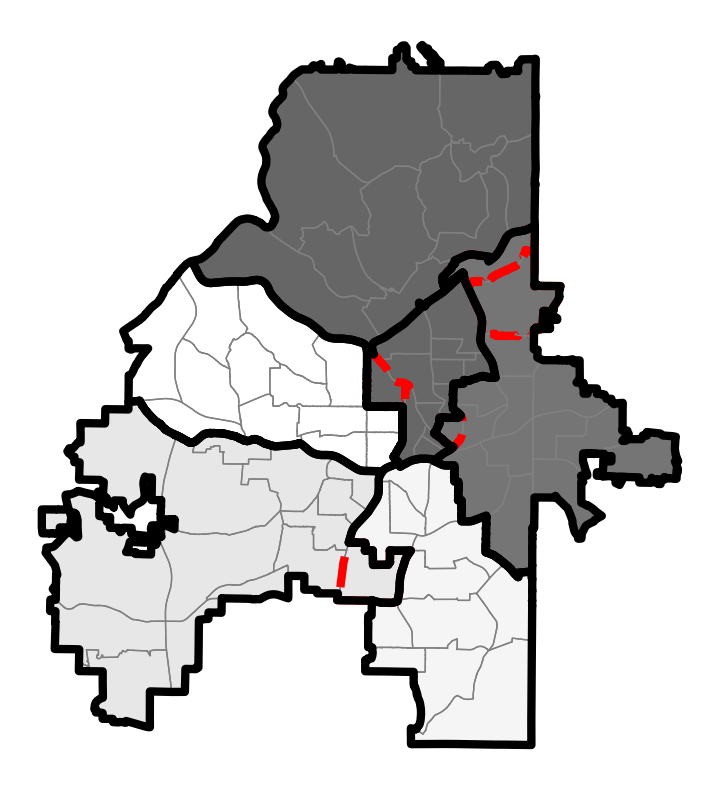

init variance: 16.779355892893193
variance: 9.36727144995151


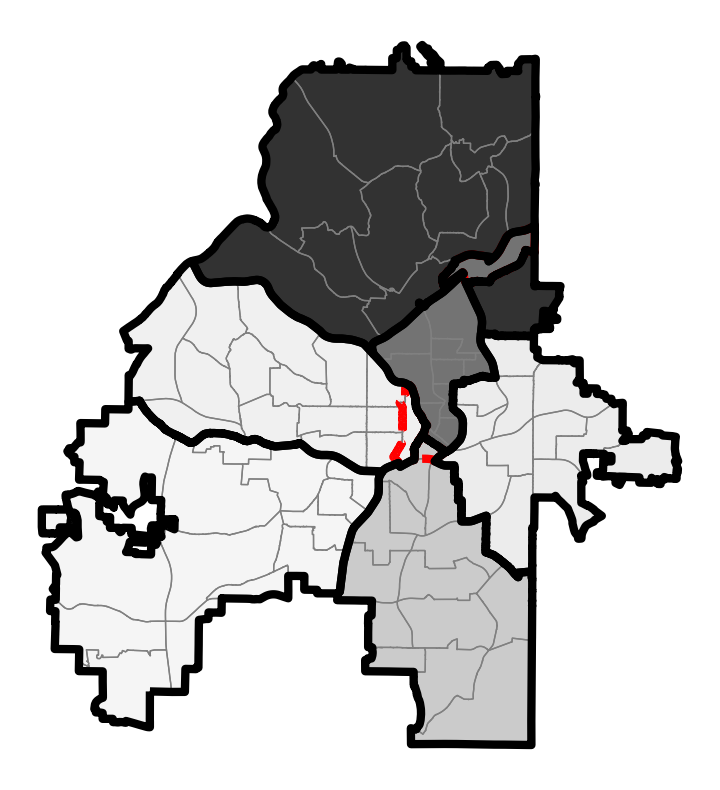

init variance: 16.779355892893193
variance: 9.552025823810158


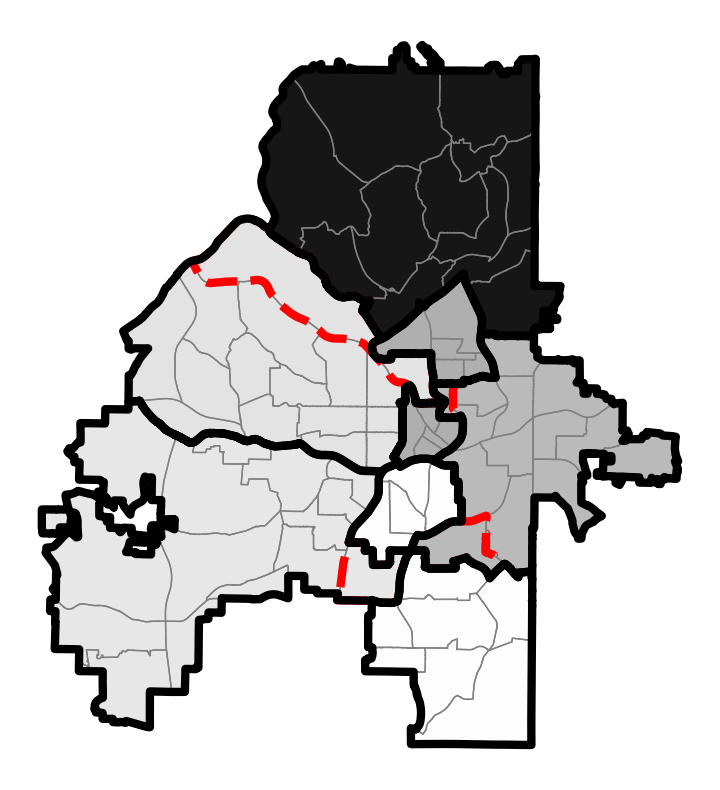

init variance: 16.779355892893193
variance: 9.095721747310357


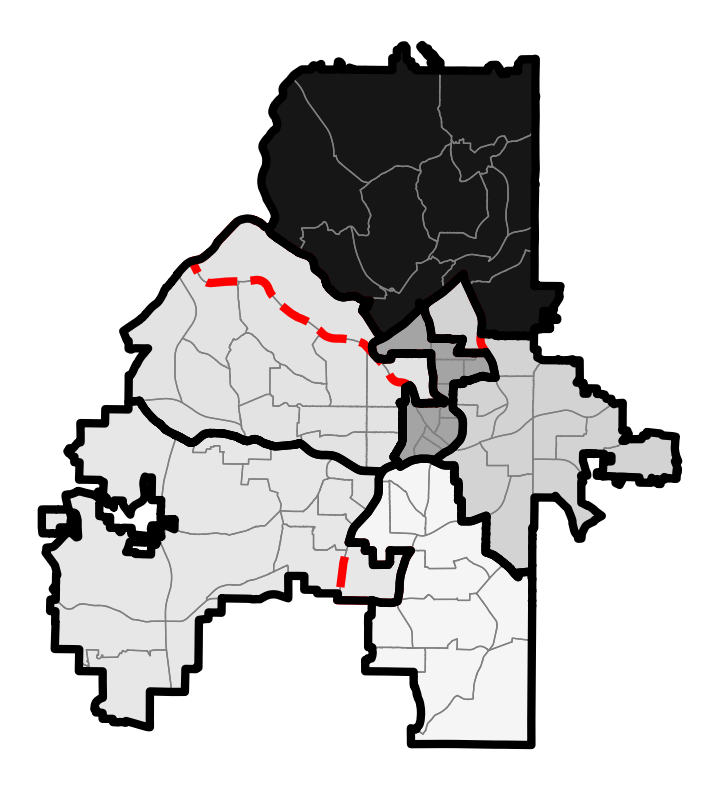

init variance: 16.779355892893193
variance: 11.650458303639576


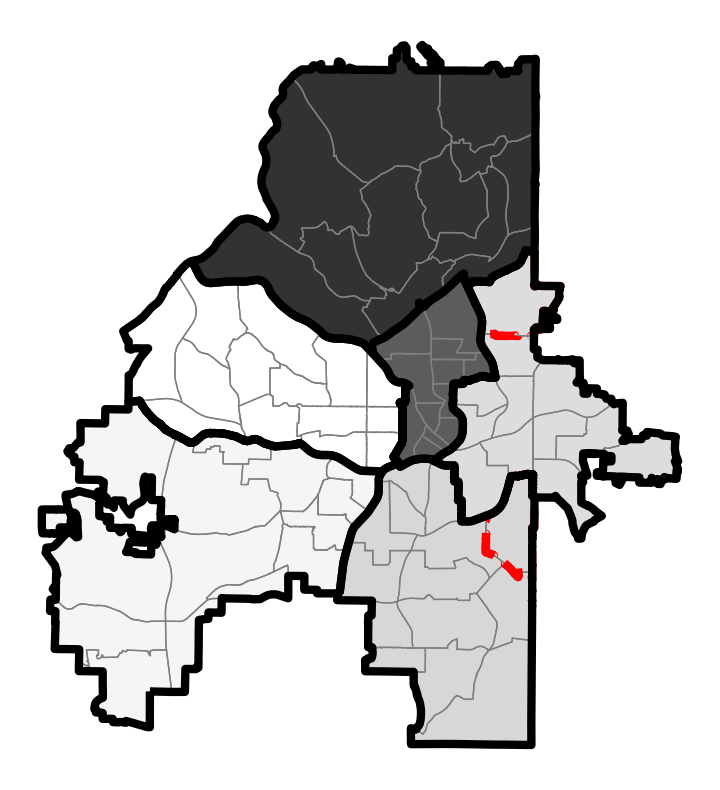

init variance: 16.779355892893193
variance: 11.507853030991319


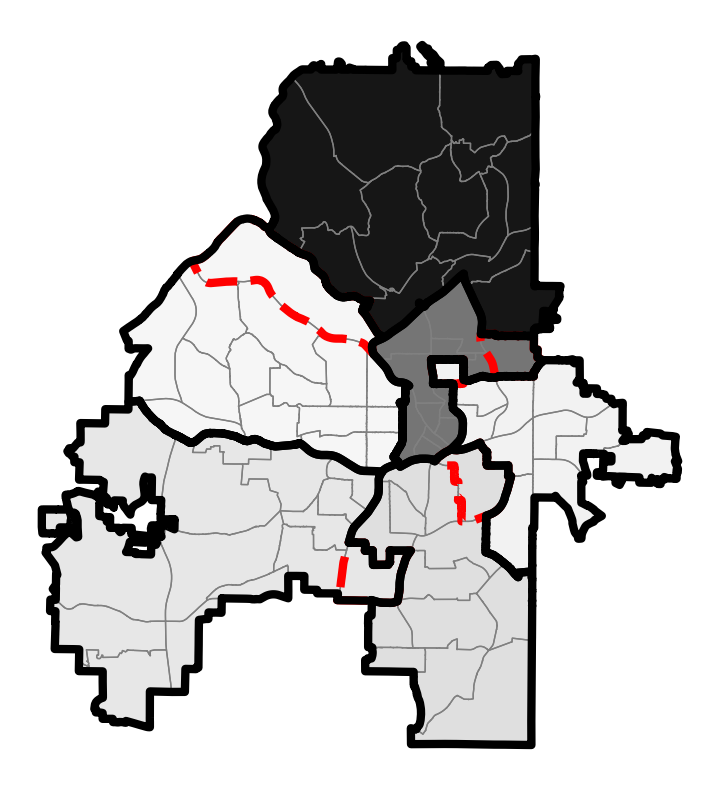

init variance: 16.779355892893193
variance: 8.797159938623901


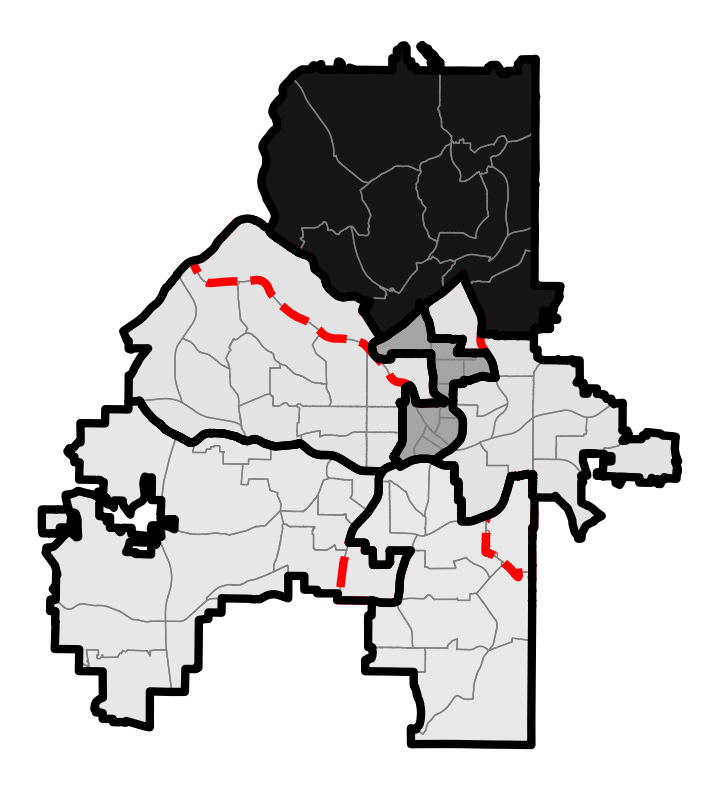

init variance: 16.779355892893193
variance: 8.434417611606785


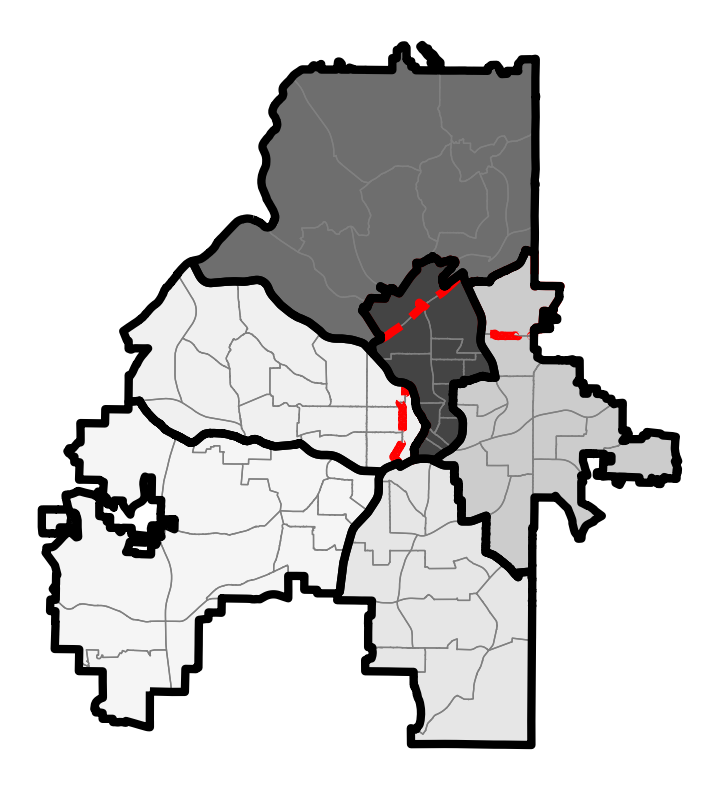

init variance: 16.779355892893193
variance: 8.434417611606785


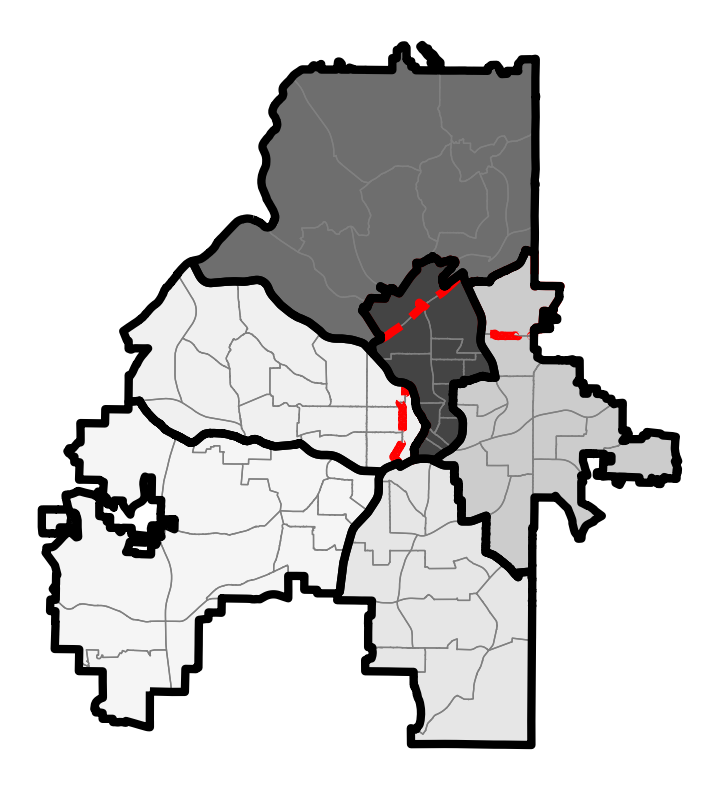

init variance: 16.779355892893193
variance: 8.434417611606785


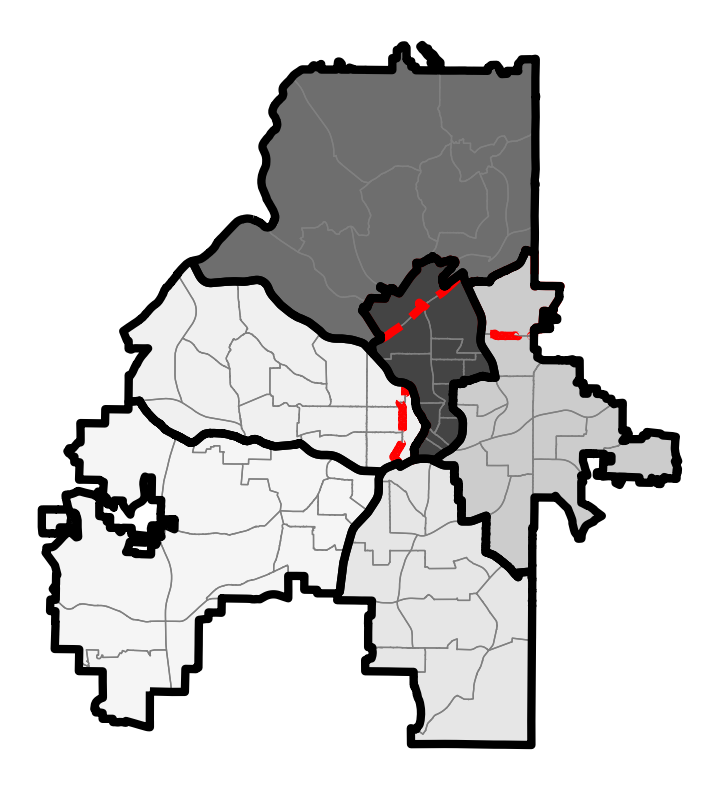

init variance: 16.779355892893193
variance: 9.75638889373531


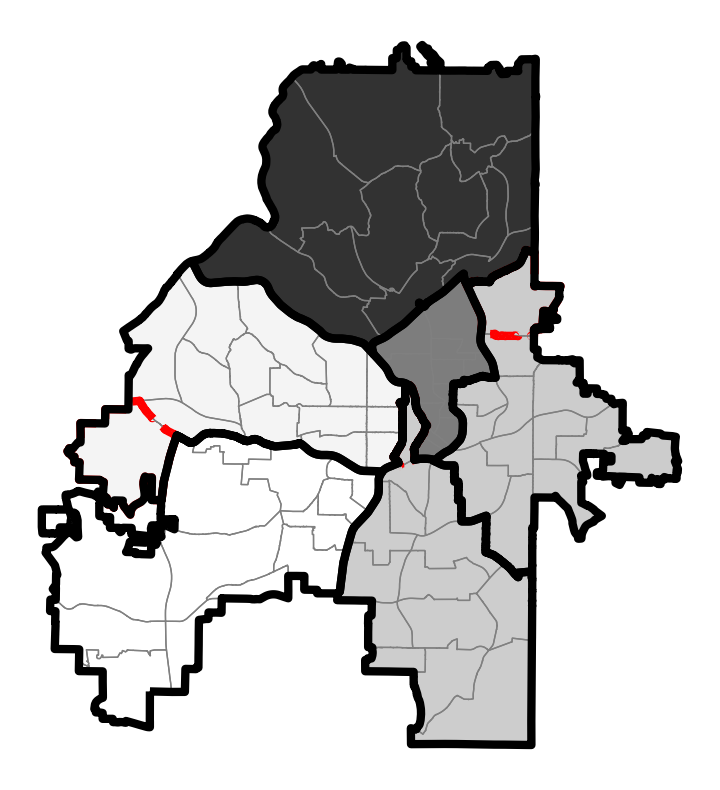

init variance: 16.779355892893193
variance: 12.624193219969753


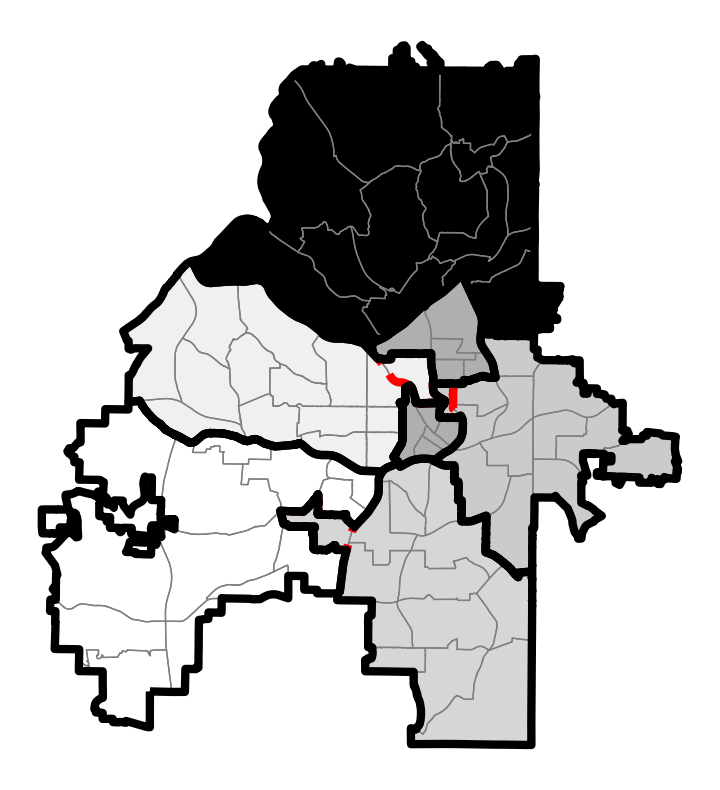

init variance: 16.779355892893193
variance: 9.095721747310357


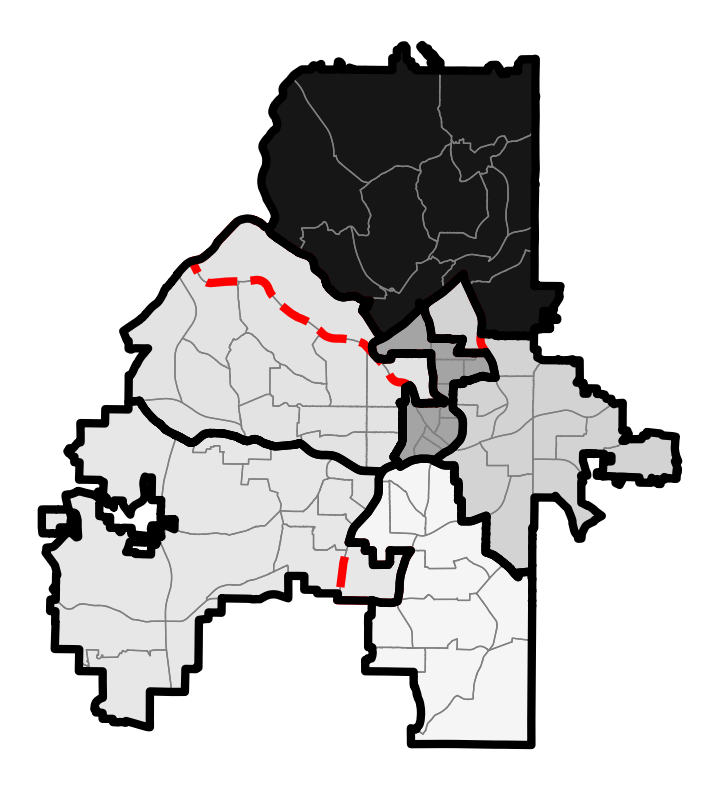

init variance: 16.779355892893193
variance: 11.524638467042323


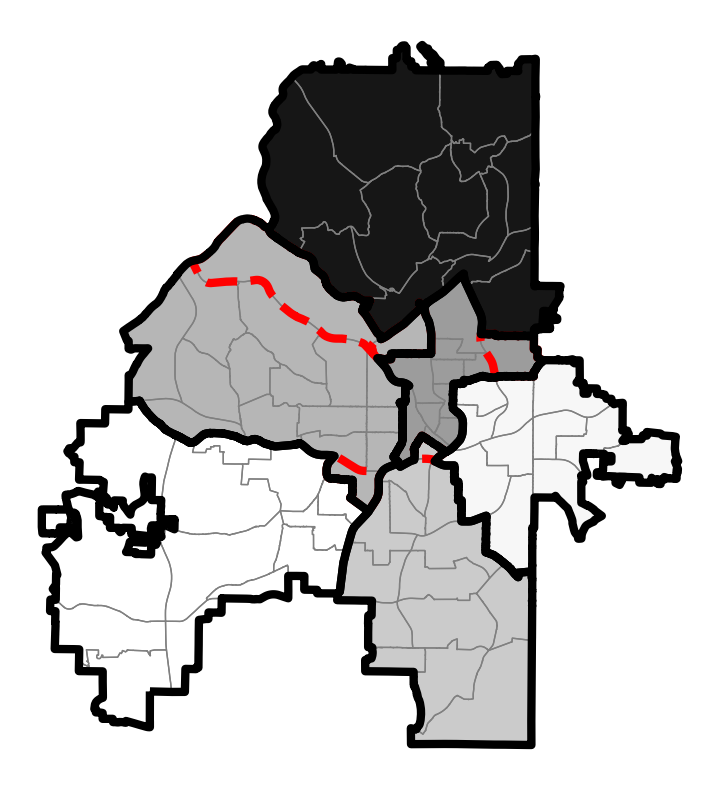

init variance: 16.779355892893193
variance: 12.24003794951648


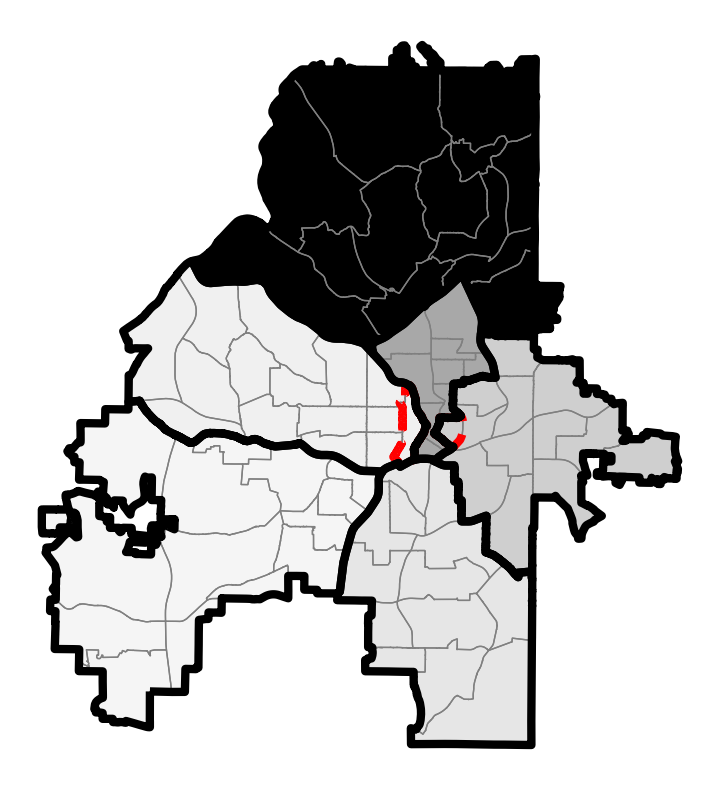

init variance: 16.779355892893193
variance: 10.611844000704645


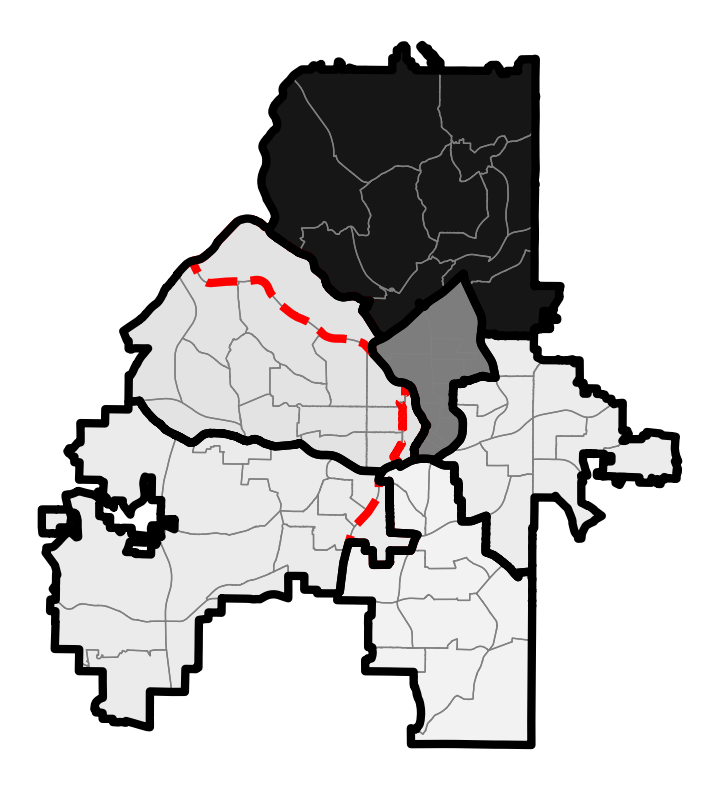

init variance: 16.779355892893193
variance: 11.070187803779476


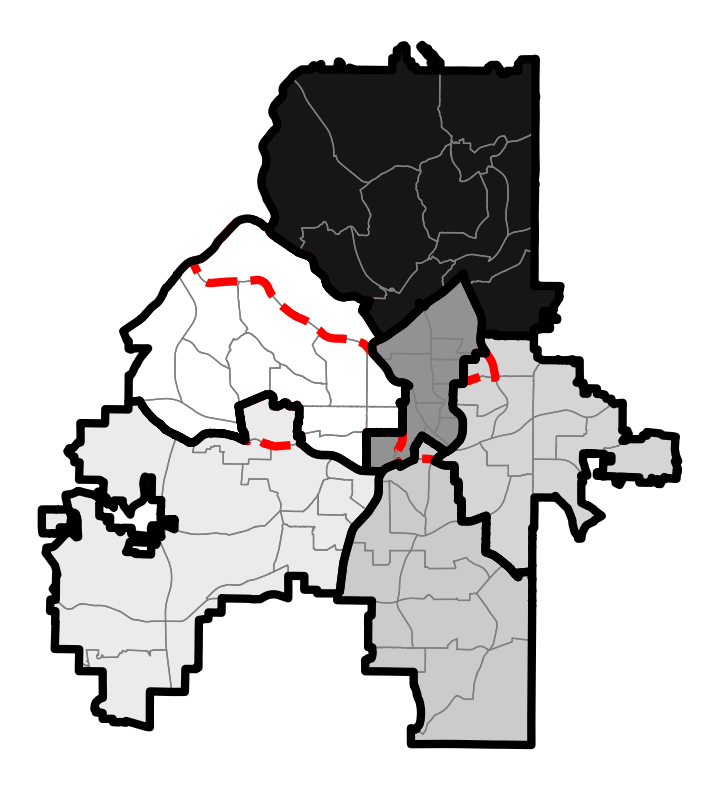

init variance: 16.779355892893193
variance: 7.164760209290755


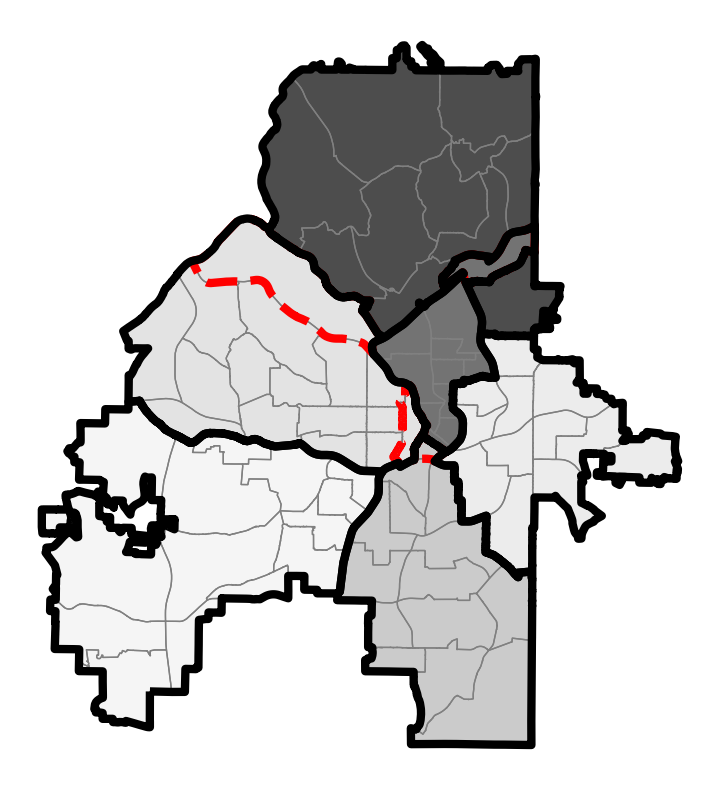

init variance: 16.779355892893193
variance: 9.330661392974289


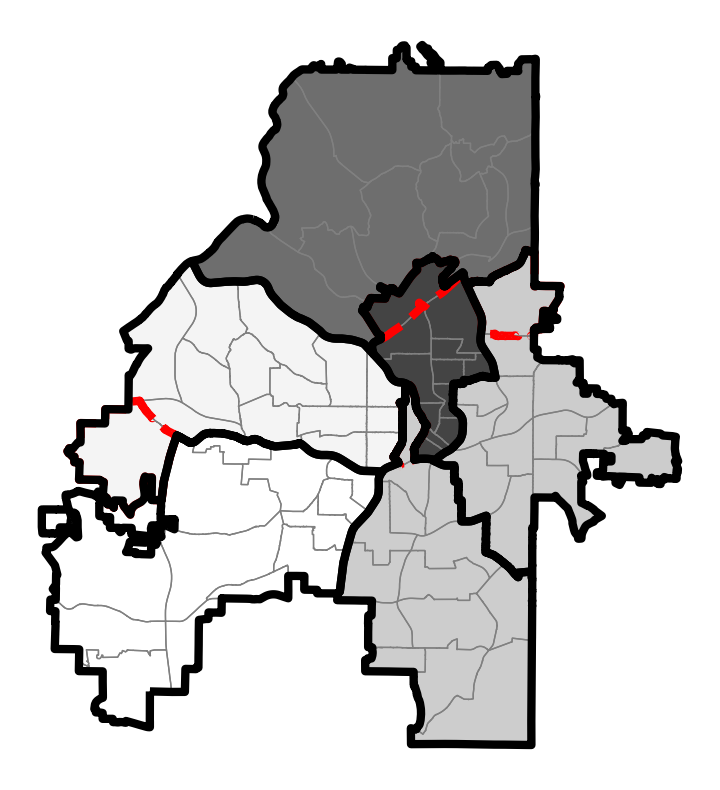

init variance: 16.779355892893193
variance: 12.632780211912745


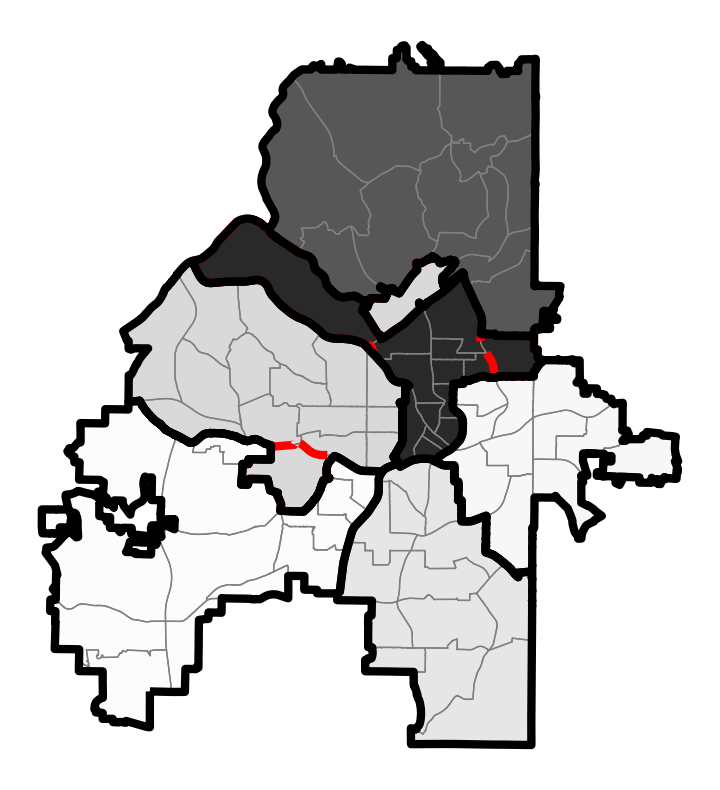

init variance: 16.779355892893193
variance: 9.552025823810158


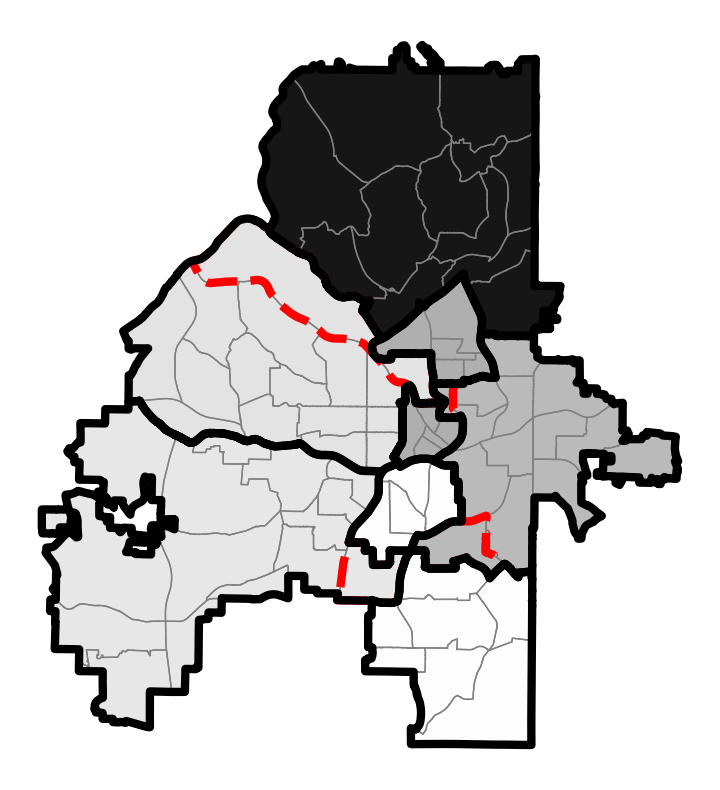

init variance: 16.779355892893193
variance: 7.164760209290755


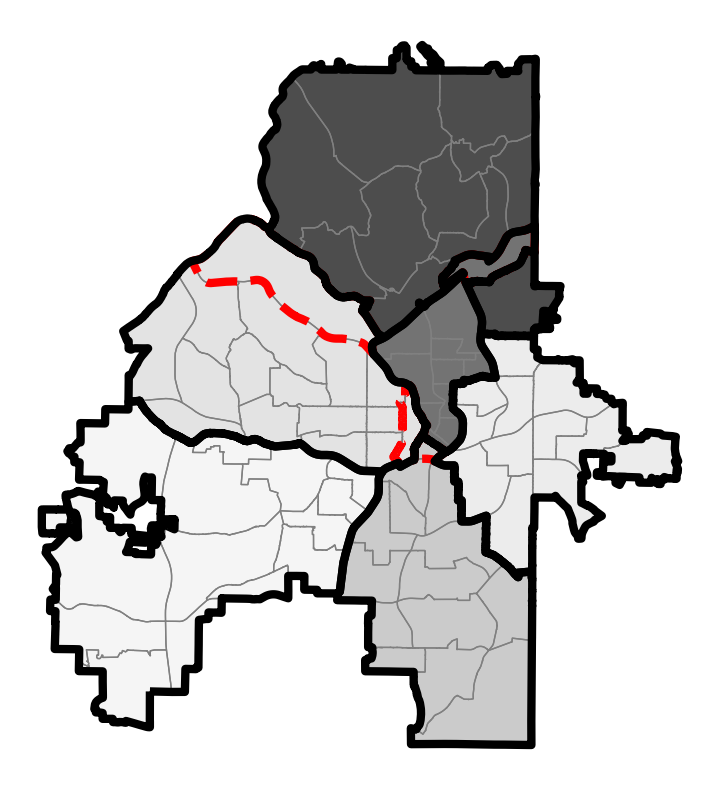

init variance: 16.779355892893193
variance: 10.399442933952955


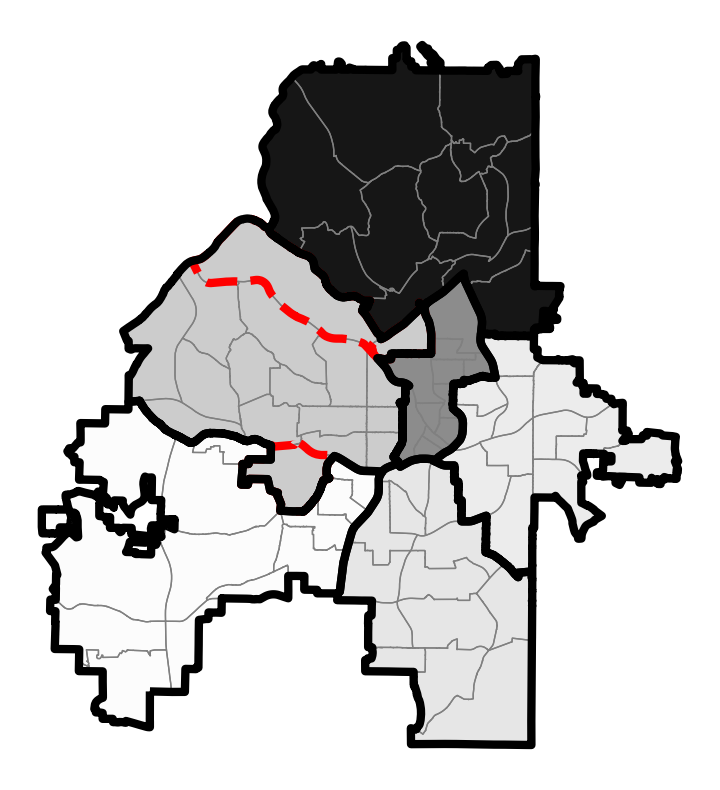

init variance: 16.779355892893193
variance: 11.339667455321507


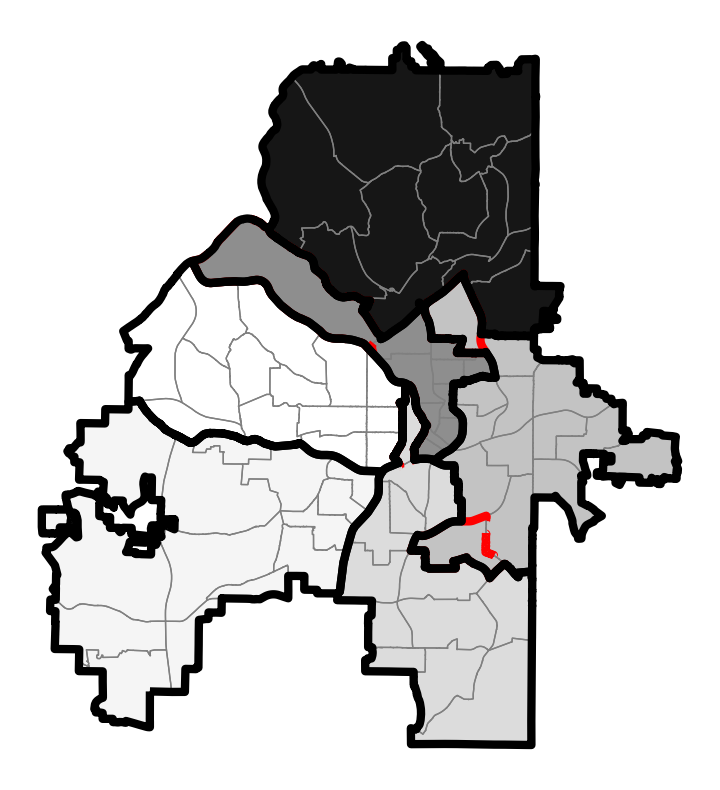

init variance: 16.779355892893193
variance: 9.36727144995151


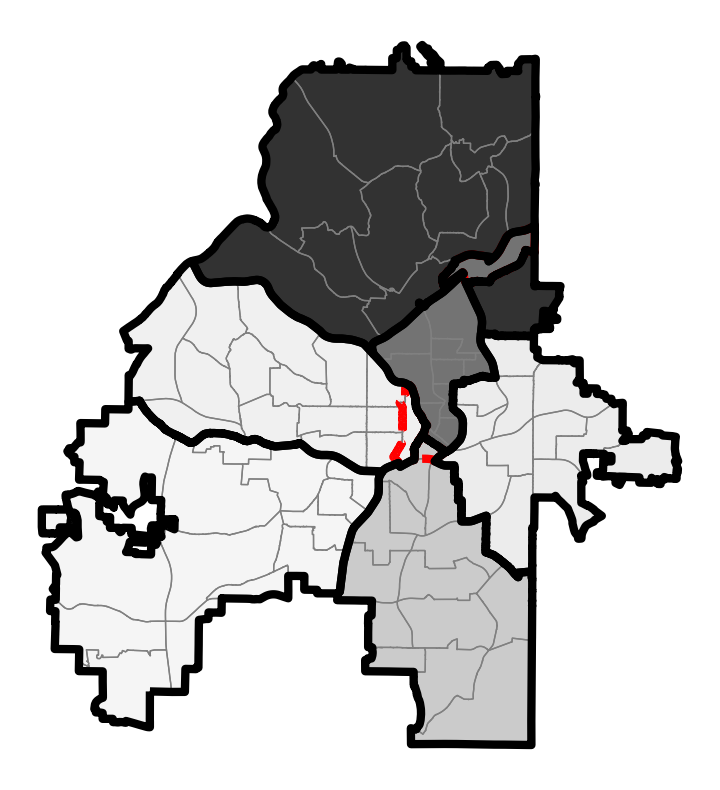

init variance: 16.779355892893193
variance: 10.526827070783463


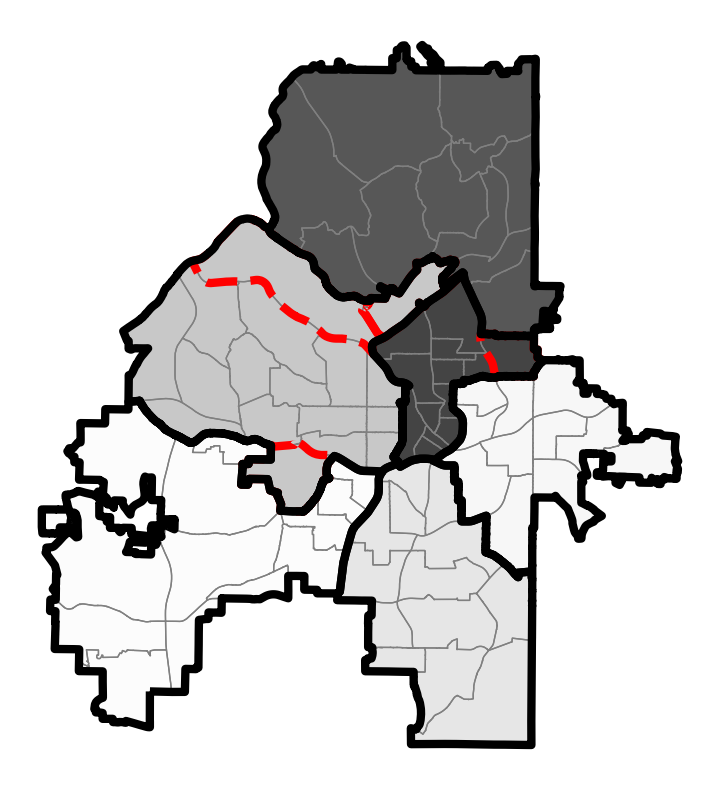

init variance: 16.779355892893193
variance: 8.797159938623901


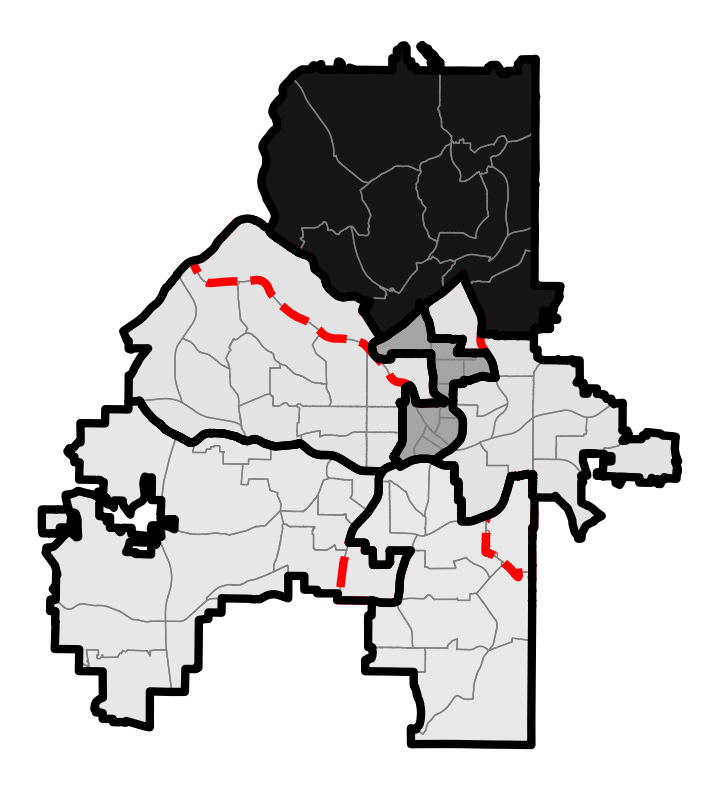

init variance: 16.779355892893193
variance: 13.05396765846417


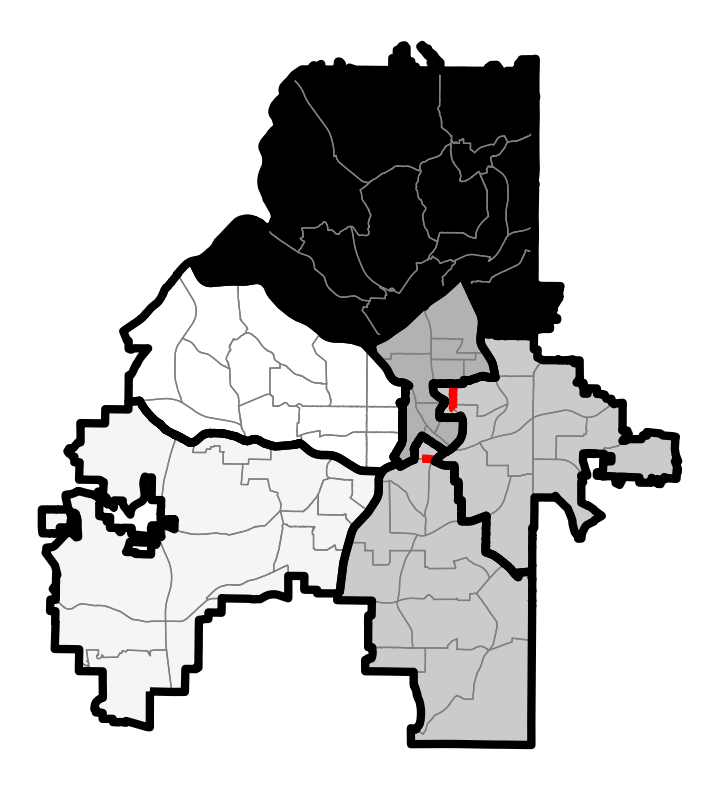

init variance: 16.779355892893193
variance: 12.478176853377231


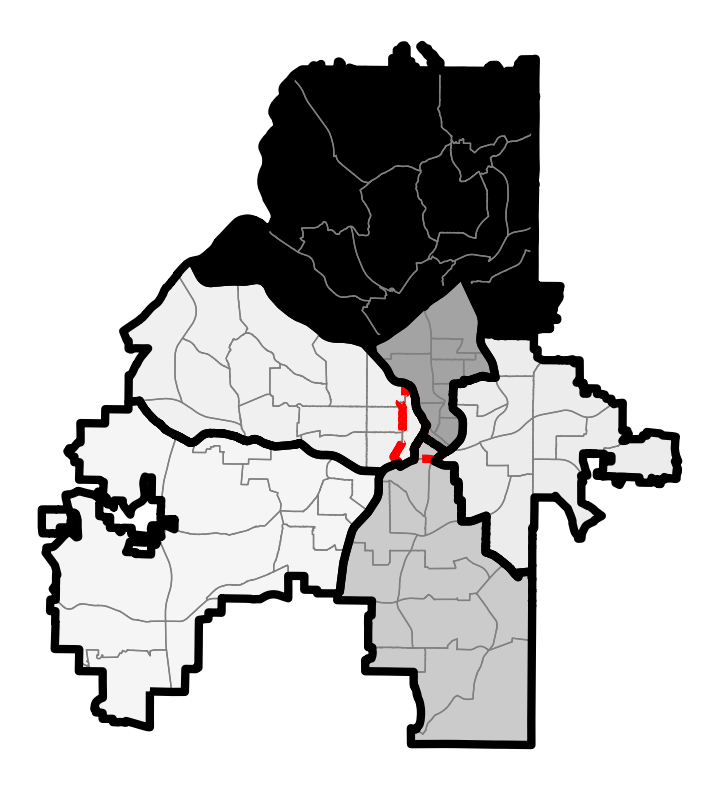

init variance: 16.779355892893193
variance: 9.75638889373531


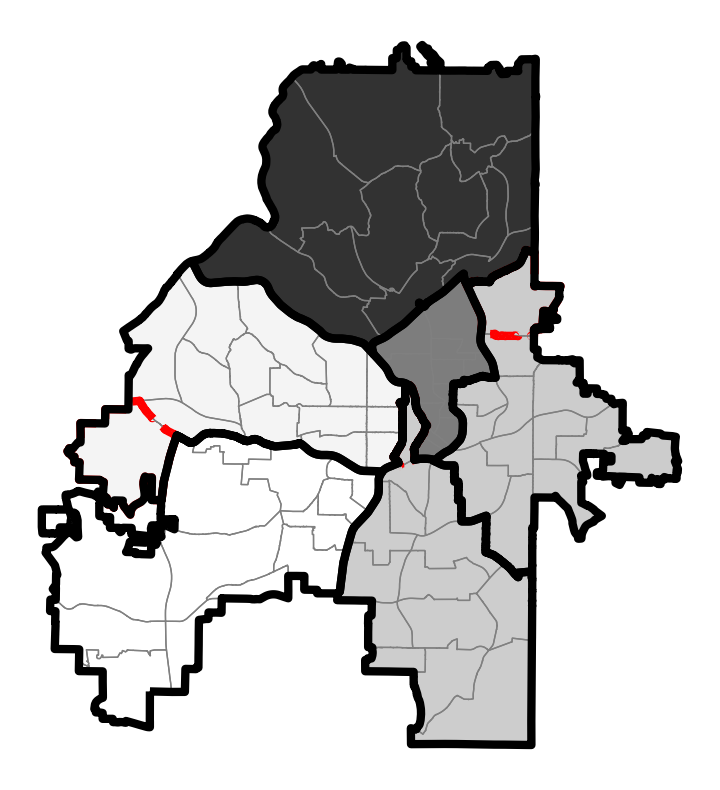

init variance: 16.779355892893193
variance: 11.00582014485953


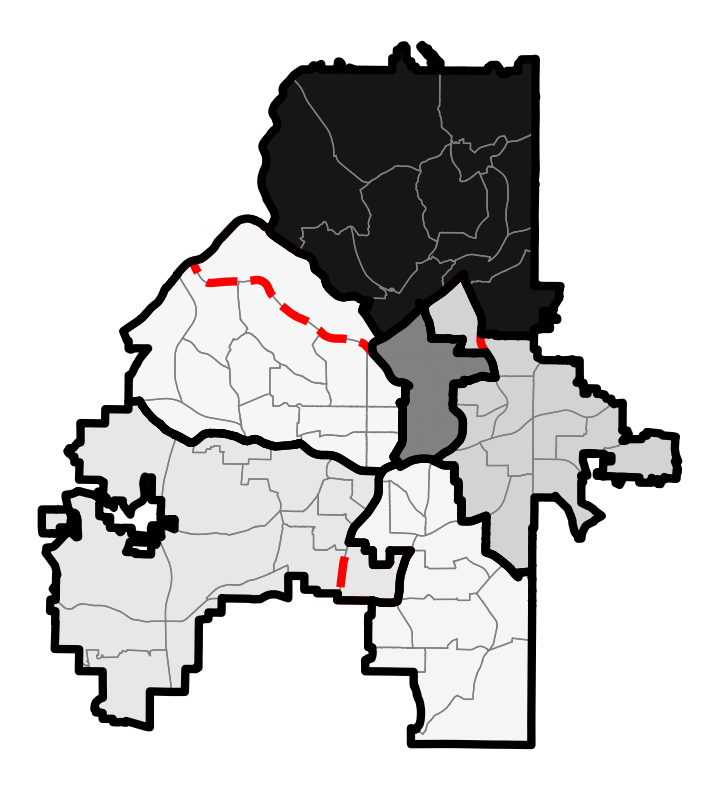

init variance: 16.779355892893193
variance: 7.164760209290755


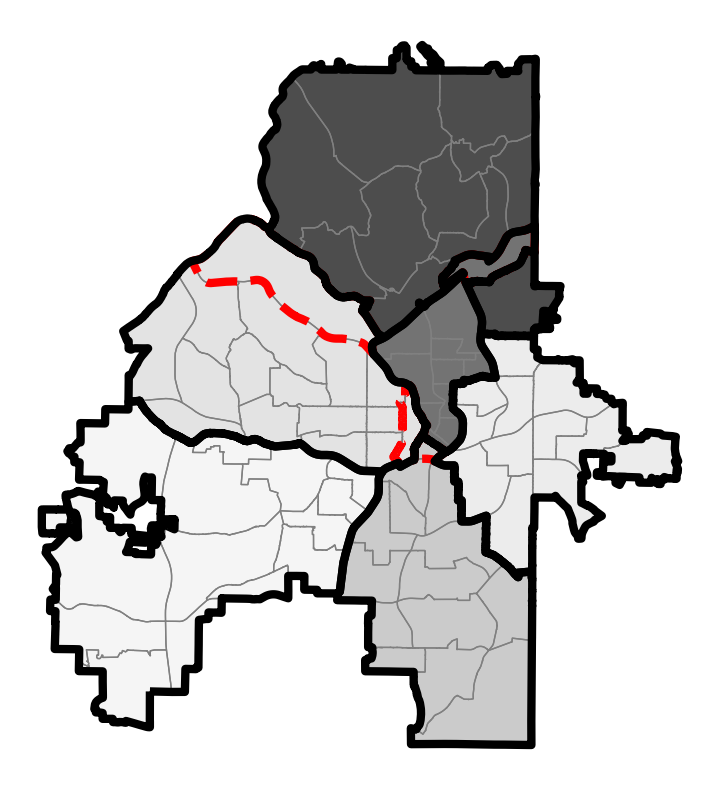

init variance: 16.779355892893193
variance: 10.032929591099478


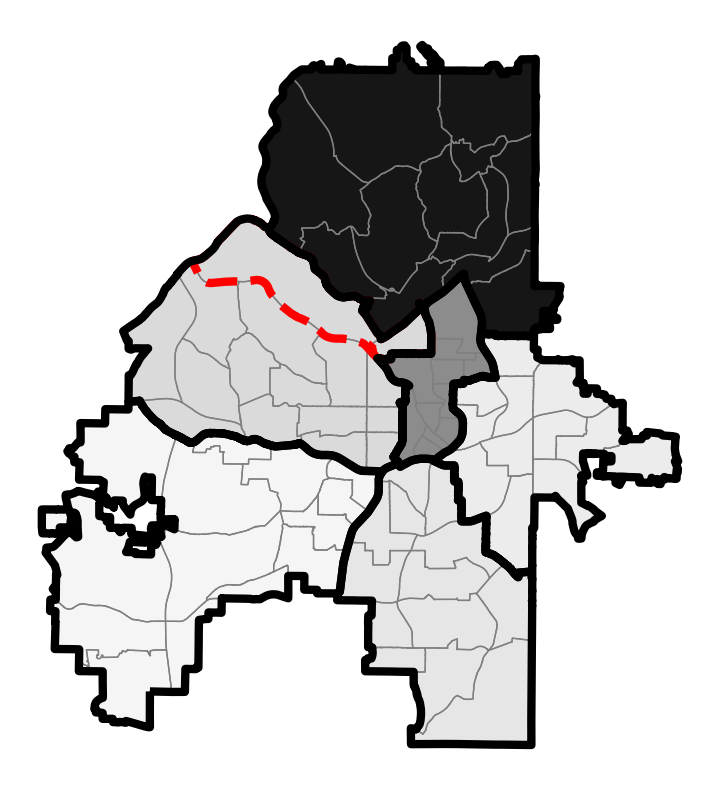

init variance: 16.779355892893193
variance: 12.104494759268379


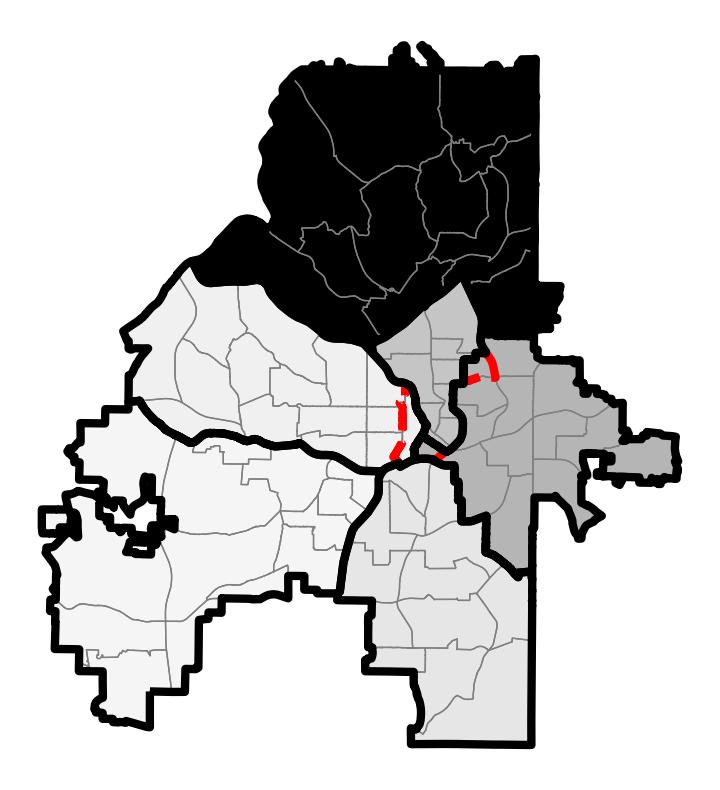

In [ ]:
T     = 200 # Number of iterations
distr = Redistricting(p=.02, length_scale=5e-1,
                      geojson_file="2011beat.geojson",
                      workload_file="workload.csv",
                      n_swap=5, n=200)
dis   = DIS_GC(distr, m=5, n=50, T=T, noise_level=2e-2, rate=1., verbose=False)

for idx in dis.opt_inds:
    zones = distr.convert_a_to_zones(distr.A[idx])
    plot_districting(distr.init_zones, zones, distr.workloads, distr.gdf)

### Generative Curation vis Simple Generative Model

Epoch [0/500], Loss: 0.0574
Epoch [100/500], Loss: -0.3161
Epoch [200/500], Loss: -0.4126
Epoch [300/500], Loss: -0.4165
Epoch [400/500], Loss: -0.4137


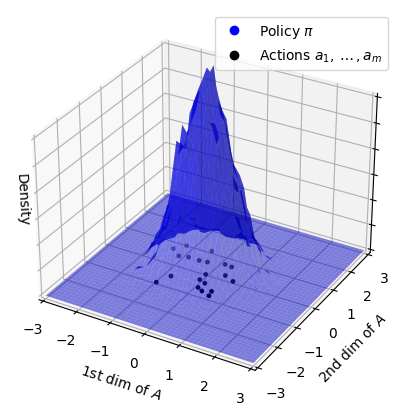

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

class SimpleGenerativeModel(nn.Module):

    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SimpleGenerativeModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, z):
        h = torch.relu(self.fc1(z))
        x = torch.tanh(self.fc2(h)) * 3
        return x

def y(a, d=2):
    z = 20
    b = 0.2
    c = 2 * np.pi
    sum1 = torch.sum(a**2, dim=1)
    sum2 = torch.sum(torch.cos(c * a), dim=1)
    term1 = -z * torch.exp(-b * torch.sqrt(sum1 / d))
    term2 = -torch.exp(sum2 / d)
    return - term1 - term2 - z - np.exp(1)

def k(A1, A2, length_scale=5e-1):
    diff         = A1 - A2
    squared_diff = torch.sum(diff ** 2, dim=1)
    distances    = torch.exp(-squared_diff / length_scale)
    return distances

def ackley_loss(model, z1, z2, z3, p=.1):
    actions1 = model(z1)
    actions2 = model(z2)
    actions3 = model(z3)

    term1 = torch.mean(y(actions1))
    term2 = torch.mean(k(actions2, actions3))
    return p * term1 + (1-p) * torch.sqrt(1 - term2)

# Parameters
batch_size = 64
noise_dim  = 10
hidden_dim = 1000
action_dim = 2
noise_std  = 1e-1
m          = 20

# Model, optimizer, and loss function
model     = SimpleGenerativeModel(input_dim=noise_dim, hidden_dim=hidden_dim, output_dim=action_dim)
optimizer = optim.Adam(model.parameters(), lr=5e-4)

# Example training loop
losses     = []
num_epochs = int(5e2)
for epoch in range(num_epochs):
    # Generate random noise
    z1 = torch.normal(0, noise_std, size=(m, noise_dim))
    z2 = torch.normal(0, noise_std, size=(1000, noise_dim))
    z3 = torch.normal(0, noise_std, size=(1000, noise_dim))

    loss = - ackley_loss(model, z1, z2, z3)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

    if epoch % 100 == 0:
        print(f'Epoch [{epoch}/{num_epochs}], Loss: {np.mean(losses):.4f}')
        losses = []

# Example generation of new samples
z       = torch.normal(0, noise_std, size=(10000, noise_dim))
actions = model(z).detach().numpy()

# Visualization of the empirical distribution
visualize_generative_policy(model, noise_dim, m=m)

### Comparison with Baselines

##### Ackley

In [ ]:
from tqdm import tqdm

# calculate regret
regrets_g = []
regrets_r = []
regrets_q = []
regrets_n = []
for _ in tqdm(range(100)):
    ackley = Ackley(d=2, p=.1, bound=(-3., 3.), length_scale=5e-1)
    # generative curation
    z       = torch.normal(0, noise_std, size=(20, noise_dim))
    actions = model(z).detach().numpy()
    # random guess
    a_r     = np.random.uniform(ackley.bound[0], ackley.bound[1], ackley.d)
    # quantitative optimal
    a_q, _  = ackley.quant_optimal()
    # quantitative optimal + noise
    a_n    = a_q + np.random.normal(0, .1, ackley.d)
    # regrets
    ell_n   = ackley.ell(a_n)
    ell_q   = ackley.ell(a_q)
    ell_r   = ackley.ell(a_r)
    ell_g   = np.max([ ackley.ell(a) for a in actions ])
    _, ell_star = ackley.true_optimal()
    regrets_g.append(ell_star - ell_g)
    regrets_r.append(ell_star - ell_r)
    regrets_q.append(ell_star - ell_q)
    regrets_n.append(ell_star - ell_n)

print("\n")
print(np.mean(regrets_g), np.percentile(regrets_g, 20), np.percentile(regrets_g, 80))
print(np.mean(regrets_r), np.percentile(regrets_r, 20), np.percentile(regrets_r, 80))
print(np.mean(regrets_q), np.percentile(regrets_q, 20), np.percentile(regrets_q, 80))
print(np.mean(regrets_n), np.percentile(regrets_n, 20), np.percentile(regrets_n, 80))

100%|██████████| 100/100 [01:28<00:00,  1.13it/s]



0.8094184233924014 0.2755223923870405 1.1737505622124293
2.2168367349378033 1.3937092907024322 3.0872610618321557
1.7071221101950933 1.0492234958428561 2.515379028563497
1.7708097116709487 1.055228244744482 2.6515460855715935


In [ ]:
n_samples = 100

def k(A1, A2, length_scale=5e-1):
    diff         = A1 - A2
    squared_diff = np.sum(diff ** 2, axis=1)
    distances    = np.exp(-squared_diff / length_scale)
    return distances

def div(A1, A2):
    rho = np.mean(k(A1, A2))
    return np.sqrt(1 - rho)

ackley = Ackley(d=2, p=.1, bound=(-3., 3.), length_scale=5e-1)
# generative curation
z     = torch.normal(0, noise_std, size=(n_samples, noise_dim))
a_gen = model(z).detach().numpy()
# random guess
a_ran = np.random.uniform(ackley.bound[0], ackley.bound[1], (n_samples, ackley.d))
# quantitative optimal
a_qua = np.array([ ackley.quant_optimal()[0] for _ in range(n_samples) ])
# quantitative optimal + noise
a_noi = a_qua + np.random.normal(0, .1, (n_samples, ackley.d))

print(div(a_gen[:50], a_gen[50:]), div(a_ran[:50], a_ran[50:]), div(a_qua[:50], a_qua[50:]), div(a_noi[:50], a_noi[50:]))

0.8534713140023633 0.9794664477104192 0.0 0.29537708558706155


##### Knapsack

In [ ]:
from tqdm import tqdm

weights    = np.random.randint(0, 10, size=10)
values     = np.random.randint(0, 10, size=10)
max_weight = 20

def perturbate_binary_vector(binary_vector, m):
    # Get indices of the binary vector
    indices = np.arange(len(binary_vector))

    # Randomly select m indices to perturbate
    perturb_indices = np.random.choice(indices, size=m, replace=False)

    # Flip the selected indices in the binary vector
    perturbed_vector = binary_vector.copy()
    perturbed_vector[perturb_indices] = 1 - perturbed_vector[perturb_indices]

    return perturbed_vector

# calculate regret
regrets_g = []
regrets_r = []
regrets_q = []
regrets_n = []
for _ in tqdm(range(100)):
    knap = Knapsack(p=.1, length_scale=5e-1,
                    weights=weights,
                    values=values,
                    max_weight=max_weight)
    ell_n, ell_q, ell_r = 0, 0, 0
    for _ in range(1):
        # random guess
        a_r     = np.random.randint(2, size=knap.d)
        # quantitative optimal
        a_q, _  = knap.quant_optimal()
        # quantitative optimal + noise
        a_n     = perturbate_binary_vector(a_q, m=2)
        # regrets
        ell_n   = max(knap.ell(a_n), ell_n)
        ell_q   = max(knap.ell(a_q), ell_q)
        ell_r   = max(knap.ell(a_r), ell_r)

    _, ell_star = knap.true_optimal()
    regrets_r.append(ell_star - ell_r)
    regrets_q.append(ell_star - ell_q)
    regrets_n.append(ell_star - ell_n)

print("\n")
print(np.mean(regrets_r), np.percentile(regrets_r, 20), np.percentile(regrets_r, 80))
print(np.mean(regrets_q), np.percentile(regrets_q, 20), np.percentile(regrets_q, 80))
print(np.mean(regrets_n), np.percentile(regrets_n, 20), np.percentile(regrets_n, 80))

100%|██████████| 100/100 [00:05<00:00, 19.37it/s]



1.122772848351336 0.048591310077636785 2.291725854598954
0.7713035686004881 0.1559908716460548 1.3852466454434766
0.8944348532153384 0.031142223848278618 1.8755734918757938


In [ ]:
n_samples = 100

def div(A1, A2, length_scale=5e-1):
    # Compute the Hamming distance matrix
    hdist = cdist(A1, A2, metric='hamming')
    # Compute the covariance matrix using the RBF kernel
    K = np.exp(- .5 * hdist / length_scale)
    rho = np.mean(K)
    return np.sqrt(1 - rho)

knap = Knapsack(p=.1, length_scale=5e-1,
                weights=weights,
                values=values,
                max_weight=max_weight)
# random guess
a_ran = np.random.randint(2, size=(n_samples, knap.d))
# quantitative optimal
a_qua = np.array([ knap.quant_optimal()[0] for _ in range(n_samples) ])
# quantitative optimal + noise
a_noi = np.stack([ perturbate_binary_vector(a, m=2) for a in a_qua ], 0)

print(div(a_ran[:50], a_ran[50:]), div(a_qua[:50], a_qua[50:]), div(a_noi[:50], a_noi[50:]))

0.6233448593196286 0.0 0.5181997846375231


##### Police Redistricting

In [ ]:
from tqdm import tqdm

n_swap     = 30
n          = 100
m          = 5
num_trails = 20

# calculate regret
regrets_g = []
regrets_r = []
regrets_q = []
regrets_n = []
for _ in tqdm(range(num_trails)):
    distr = Redistricting(p=1e-1, length_scale=5e-1,
                          geojson_file="2011beat.geojson",
                          workload_file="workload.csv",
                          n_swap=n_swap, n=n)
    ell_n, ell_q, ell_r = -999, -999, -999
    for _ in range(1):
        # random guess
        i_r     = np.random.randint(distr.A.shape[0])
        # quantitative optimal
        a_q, _  = distr.quant_optimal()
        # regrets
        ell_q   = max(distr.ell(a_q), ell_q)
        ell_r   = max(distr.ell(distr.A[i_r]), ell_r)

    _, ell_star = distr.true_optimal()
    regrets_r.append(ell_star - ell_r)
    regrets_q.append(ell_star - ell_q)

print("\n")
print(np.mean(regrets_r), np.percentile(regrets_r, 20), np.percentile(regrets_r, 80))
print(np.mean(regrets_q), np.percentile(regrets_q, 20), np.percentile(regrets_q, 80))



2.3735633768264055 1.5093267103306576 3.1659346050535073
0.18794024606917123 -0.017945901116418694 0.3694071885491737
